In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import plotly.express as px
import matplotlib.dates as mdates
import datetime

In [36]:

import matplotlib.colors as mcolors
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import warnings
warnings.filterwarnings("ignore")

## Downloading the Raw Dataset

In [37]:
confirmedDF = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deathsDF = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveredDF = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latestData = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/05-10-2021.csv')

In [38]:
confirmedDF.shape

(275, 480)

In [39]:
confirmedDF.head()

Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  5/2/21  5/3/21  5/4/21  5/5/21  \
0        0        0        0        0  ...   60122   60300   60563   60797   
1        0        0        0        0  ...  131238  131276  131327  131419   
2        0        0        0        0  ...  122522  122717  122999  123272   
3        0        0        0        0  ...   13282   13295   13316   13340   
4        0        0        0        0  ...   26993   27133   27284   27529   

   5/6/21  5/7/21  5/8/21  5/9/21  5/10/21  5/11/21  
0   61162   61455   61755   61842    62063    62403  
1  131510  131577  131666  131723   131753   131803  
2  123473  123692  123900  124104   124288   124483  
3   13363   13390   13406   13423    13429    13447  
4   27921   28201   28477   28740    28875    29146  

[5 rows x 480 columns]

## Loading the dataset and Extracting the date list

In [40]:
confirmedDF.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '5/2/21', '5/3/21', '5/4/21', '5/5/21', '5/6/21', '5/7/21', '5/8/21',
       '5/9/21', '5/10/21', '5/11/21'],
      dtype='object', length=480)

In [41]:
confirmedDF.columns[4:]

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '5/2/21', '5/3/21', '5/4/21', '5/5/21', '5/6/21', '5/7/21', '5/8/21',
       '5/9/21', '5/10/21', '5/11/21'],
      dtype='object', length=476)

In [42]:
cols = confirmedDF.keys()
confirmed = confirmedDF.loc[:, cols[4]:cols[-1]]
deaths = deathsDF.loc[:, cols[4]:cols[-1]]

dates = confirmed.keys()

In [43]:
dates = confirmed.keys()
globalCases = []
globalDeaths = [] 
mortalRate = []

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    
    # confirmed, deaths, recovered, and active
    globalCases.append(confirmed_sum)
    globalDeaths.append(death_sum)
    
    # calculate rates
    mortalRate.append(death_sum/confirmed_sum)

In [44]:
daysFromBeginning = np.array([i for i in range(len(dates))]).reshape(-1, 1)
globalCases = np.array(globalCases).reshape(-1, 1)
globalDeaths = np.array(globalDeaths).reshape(-1, 1)

In [45]:
daysInFuture = 25
future_forcast = np.array([i for i in range(len(dates)+daysInFuture)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

### Converting dates for better visualization

In [46]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
forcastDatesFuture = []
for i in range(len(future_forcast)):
    forcastDatesFuture.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [47]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(daysFromBeginning[50:], globalCases[50:], test_size=0.03, shuffle=False) 

In [48]:
# svmConfirmed = svm_search.best_estimator_
svmConfirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svmConfirmed.fit(X_train_confirmed, y_train_confirmed)
svmPred = svmConfirmed.predict(future_forcast)

In [49]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=4)
polyXTrainConfirmed = poly.fit_transform(X_train_confirmed)
polyXTestConfirmed = poly.fit_transform(X_test_confirmed)
polyFutureForecast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=5)
bayesian_polyXTrainConfirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_polyXTestConfirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_polyFutureForecast = bayesian_poly.fit_transform(future_forcast)

In [50]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(polyXTrainConfirmed, y_train_confirmed)
test_linearPred = linear_model.predict(polyXTestConfirmed)
linearPred = linear_model.predict(polyFutureForecast)
print('MAE:', mean_absolute_error(test_linearPred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linearPred, y_test_confirmed))

MAE: 9912458.415716115
MSE: 101482860839281.27


In [51]:
print(linear_model.coef_)

[[-1.20227769e+07  3.29180905e+05 -2.80323598e+03  1.22427972e+01
  -1.32982466e-02]]


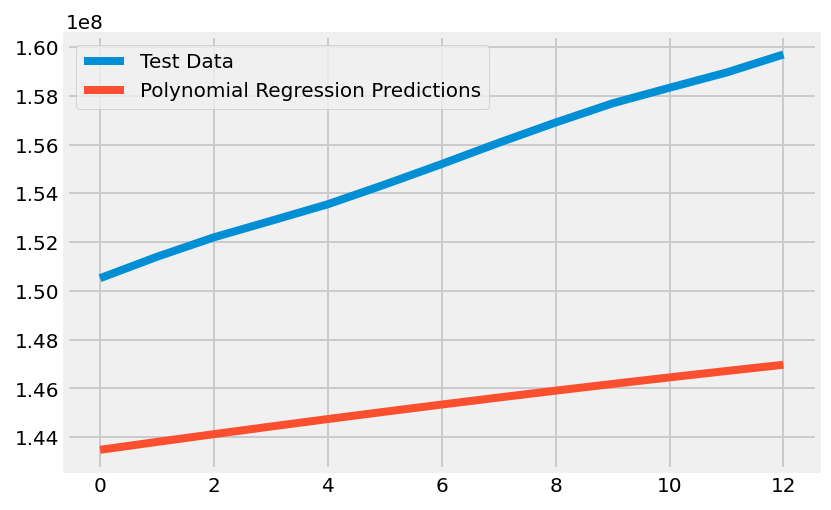

In [52]:
plt.plot(y_test_confirmed)
plt.plot(test_linearPred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

In [53]:
# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_polyXTrainConfirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.5s finished


RandomizedSearchCV(cv=3, estimator=BayesianRidge(fit_intercept=False),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'lambda_2': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'normalize': [True, False],
                                        'tol': [1e-06, 1e-05, 0.0001, 0.001,
                                                0.01]},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [54]:
bayesian_search.best_params_

{'tol': 0.001,
 'normalize': True,
 'lambda_2': 1e-05,
 'lambda_1': 0.001,
 'alpha_2': 1e-06,
 'alpha_1': 0.001}

In [55]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesianPred = bayesian_confirmed.predict(bayesian_polyXTestConfirmed)
bayesianPred = bayesian_confirmed.predict(bayesian_polyFutureForecast)
print('MAE:', mean_absolute_error(test_bayesianPred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesianPred, y_test_confirmed))

MAE: 8951109.317543985
MSE: 82879610953108.75


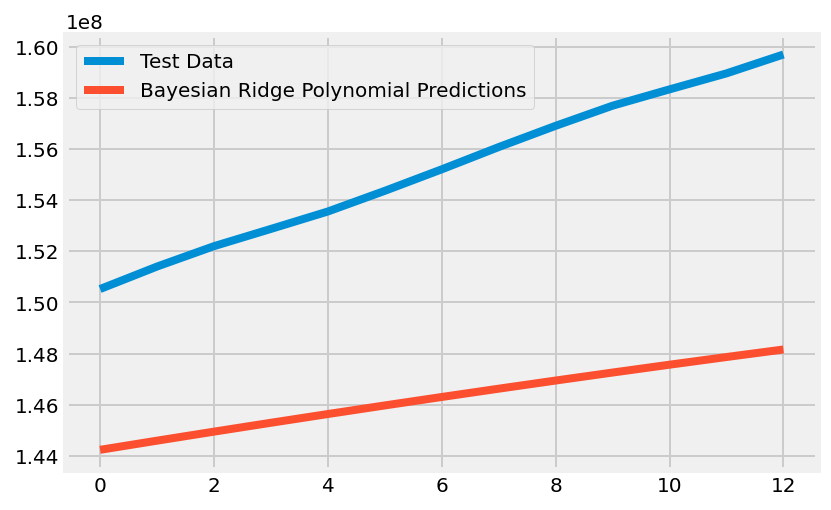

In [56]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesianPred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

## Merging the confirmedDF, deathsDF and recoveredDF

In [57]:
date_values = confirmedDF.columns[4:]

confirmedDFLong = confirmedDF.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=date_values, 
    var_name='Date', 
    value_name='Confirmed'
)
deathsDFLong = deathsDF.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=date_values, 
    var_name='Date', 
    value_name='Deaths'
)
recoveredDFLong = recoveredDF.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=date_values, 
    var_name='Date', 
    value_name='Recovered'
)

### Converting to new long DataFrames. 
### All of them are ordered by Date and Country/Region because raw data was already ordered by Country/Region and the date columns are already in ASC order.

In [58]:
confirmedDFLong.head()

Province/State Country/Region       Lat       Long     Date  Confirmed
0            NaN    Afghanistan  33.93911  67.709953  1/22/20          0
1            NaN        Albania  41.15330  20.168300  1/22/20          0
2            NaN        Algeria  28.03390   1.659600  1/22/20          0
3            NaN        Andorra  42.50630   1.521800  1/22/20          0
4            NaN         Angola -11.20270  17.873900  1/22/20          0

### Canada recovered data is counted by Country-wise rather than Province/State-wise [dropping it]

In [59]:
canada_recoverd_data = recoveredDFLong[recoveredDFLong['Country/Region']=='Canada']

In [60]:
canada_recoverd_data.head()

Province/State Country/Region      Lat      Long     Date  Recovered
39              NaN         Canada  56.1304 -106.3468  1/22/20          0
299             NaN         Canada  56.1304 -106.3468  1/23/20          0
559             NaN         Canada  56.1304 -106.3468  1/24/20          0
819             NaN         Canada  56.1304 -106.3468  1/25/20          0
1079            NaN         Canada  56.1304 -106.3468  1/26/20          0

In [61]:
recoveredDFLong = recoveredDFLong[recoveredDFLong['Country/Region']!='Canada']

### Mergint the 3 dataframes

In [62]:
# Merging confirmedDFLong and deathsDFLong
fullTable = confirmedDFLong.merge(
  right=deathsDFLong, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long']
)
# Merging fullTable and recoveredDFLong
fullTable = fullTable.merge(
  right=recoveredDFLong, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long']
)

In [63]:
fullTable.head()

Province/State Country/Region       Lat       Long     Date  Confirmed  \
0            NaN    Afghanistan  33.93911  67.709953  1/22/20          0   
1            NaN        Albania  41.15330  20.168300  1/22/20          0   
2            NaN        Algeria  28.03390   1.659600  1/22/20          0   
3            NaN        Andorra  42.50630   1.521800  1/22/20          0   
4            NaN         Angola -11.20270  17.873900  1/22/20          0   

   Deaths  Recovered  
0       0        0.0  
1       0        0.0  
2       0        0.0  
3       0        0.0  
4       0        0.0

### Data Cleaning

#### Handling the date values

In [64]:
fullTable['Date'] = pd.to_datetime(fullTable['Date'])

In [65]:
fullTable.head()

Province/State Country/Region       Lat       Long       Date  Confirmed  \
0            NaN    Afghanistan  33.93911  67.709953 2020-01-22          0   
1            NaN        Albania  41.15330  20.168300 2020-01-22          0   
2            NaN        Algeria  28.03390   1.659600 2020-01-22          0   
3            NaN        Andorra  42.50630   1.521800 2020-01-22          0   
4            NaN         Angola -11.20270  17.873900 2020-01-22          0   

   Deaths  Recovered  
0       0        0.0  
1       0        0.0  
2       0        0.0  
3       0        0.0  
4       0        0.0

#### Detecting the missing values

In [66]:
fullTable.isna().sum()

Province/State    89964
Country/Region        0
Lat                 952
Long                952
Date                  0
Confirmed             0
Deaths                0
Recovered          9996
dtype: int64

In [67]:
fullTable['Recovered'] = fullTable['Recovered'].fillna(0)

#### Ship data needs to be filtered out

In [68]:
# cruise ships: Grand Princess, Diamond Princess and MS Zaandam
fullTable[fullTable['Country/Region'] == 'Diamond Princess']

Province/State    Country/Region  Lat  Long       Date  Confirmed  \
105               NaN  Diamond Princess  0.0   0.0 2020-01-22          0   
380               NaN  Diamond Princess  0.0   0.0 2020-01-23          0   
655               NaN  Diamond Princess  0.0   0.0 2020-01-24          0   
930               NaN  Diamond Princess  0.0   0.0 2020-01-25          0   
1205              NaN  Diamond Princess  0.0   0.0 2020-01-26          0   
...               ...               ...  ...   ...        ...        ...   
129630            NaN  Diamond Princess  0.0   0.0 2021-05-07        712   
129905            NaN  Diamond Princess  0.0   0.0 2021-05-08        712   
130180            NaN  Diamond Princess  0.0   0.0 2021-05-09        712   
130455            NaN  Diamond Princess  0.0   0.0 2021-05-10        712   
130730            NaN  Diamond Princess  0.0   0.0 2021-05-11        712   

        Deaths  Recovered  
105          0        0.0  
380          0        0.0  
655          0        0.0  
930          0        0.0  
1205         0        0.0  
...        ...        ...  
129630      13      699.0  
129905      13      699.0  
130180      13      699.0  
130455      13      699.0  
130730      13      699.0  

[476 rows x 8 columns]

#### Extracting the ship data and deleting from original data

In [69]:
ship_rows = fullTable['Province/State'].str.contains('Grand Princess') | fullTable['Province/State'].str.contains('Diamond Princess') | fullTable['Country/Region'].str.contains('Diamond Princess') | fullTable['Country/Region'].str.contains('MS Zaandam')
full_ship = fullTable[ship_rows]

In [70]:
fullTable = fullTable[~(ship_rows)]

#### Data aggregation (Calculating the Active cases column)

In [71]:
# Active Case = confirmed - deaths - recovered
fullTable['Active'] = fullTable['Confirmed'] - fullTable['Deaths'] - fullTable['Recovered']

In [72]:
fullTable

Province/State      Country/Region        Lat        Long       Date  \
0                 NaN         Afghanistan  33.939110   67.709953 2020-01-22   
1                 NaN             Albania  41.153300   20.168300 2020-01-22   
2                 NaN             Algeria  28.033900    1.659600 2020-01-22   
3                 NaN             Andorra  42.506300    1.521800 2020-01-22   
4                 NaN              Angola -11.202700   17.873900 2020-01-22   
...               ...                 ...        ...         ...        ...   
130895            NaN             Vietnam  14.058324  108.277199 2021-05-11   
130896            NaN  West Bank and Gaza  31.952200   35.233200 2021-05-11   
130897            NaN               Yemen  15.552727   48.516388 2021-05-11   
130898            NaN              Zambia -13.133897   27.849332 2021-05-11   
130899            NaN            Zimbabwe -19.015438   29.154857 2021-05-11   

        Confirmed  Deaths  Recovered   Active  
0               0       0        0.0      0.0  
1               0       0        0.0      0.0  
2               0       0        0.0      0.0  
3               0       0        0.0      0.0  
4               0       0        0.0      0.0  
...           ...     ...        ...      ...  
130895       3571      35     2618.0    918.0  
130896     302777    3393   287932.0  11452.0  
130897       6492    1276     3003.0   2213.0  
130898      92152    1258    90539.0    355.0  
130899      38448    1579    36221.0    648.0  

[128996 rows x 9 columns]

####  Aggregating data into Country/Region wise and group them by Date and Country/Region

In [73]:
fullGrouped = fullTable.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

In [74]:
fullGrouped

Date      Country/Region  Confirmed  Deaths  Recovered   Active
0     2020-01-22         Afghanistan          0       0        0.0      0.0
1     2020-01-22             Albania          0       0        0.0      0.0
2     2020-01-22             Algeria          0       0        0.0      0.0
3     2020-01-22             Andorra          0       0        0.0      0.0
4     2020-01-22              Angola          0       0        0.0      0.0
...          ...                 ...        ...     ...        ...      ...
90435 2021-05-11             Vietnam       3571      35     2618.0    918.0
90436 2021-05-11  West Bank and Gaza     302777    3393   287932.0  11452.0
90437 2021-05-11               Yemen       6492    1276     3003.0   2213.0
90438 2021-05-11              Zambia      92152    1258    90539.0    355.0
90439 2021-05-11            Zimbabwe      38448    1579    36221.0    648.0

[90440 rows x 6 columns]

#### add day wise New cases, New deaths and New recovered by deducting the corresponding accumulative data on the previous day.

In [75]:
# new cases 
temp = fullGrouped.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()
mask = temp['Country/Region'] != temp['Country/Region'].shift(1)
temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan
# renaming columns
temp.columns = ['Country/Region', 'Date', 'New cases', 'New deaths', 'New recovered']
# merging new values
fullGrouped = pd.merge(fullGrouped, temp, on=['Country/Region', 'Date'])
# filling na with 0
fullGrouped = fullGrouped.fillna(0)
# fixing data types
cols = ['New cases', 'New deaths', 'New recovered']
fullGrouped[cols] = fullGrouped[cols].astype('int')
fullGrouped['New cases'] = fullGrouped['New cases'].apply(lambda x: 0 if x<0 else x)

In [76]:
fullGrouped

Date      Country/Region  Confirmed  Deaths  Recovered   Active  \
0     2020-01-22         Afghanistan          0       0        0.0      0.0   
1     2020-01-22             Albania          0       0        0.0      0.0   
2     2020-01-22             Algeria          0       0        0.0      0.0   
3     2020-01-22             Andorra          0       0        0.0      0.0   
4     2020-01-22              Angola          0       0        0.0      0.0   
...          ...                 ...        ...     ...        ...      ...   
90435 2021-05-11             Vietnam       3571      35     2618.0    918.0   
90436 2021-05-11  West Bank and Gaza     302777    3393   287932.0  11452.0   
90437 2021-05-11               Yemen       6492    1276     3003.0   2213.0   
90438 2021-05-11              Zambia      92152    1258    90539.0    355.0   
90439 2021-05-11            Zimbabwe      38448    1579    36221.0    648.0   

       New cases  New deaths  New recovered  
0              0           0              0  
1              0           0              0  
2              0           0              0  
3              0           0              0  
4              0           0              0  
...          ...         ...            ...  
90435         82           0              0  
90436        528          15            726  
90437          7           1              2  
90438         40           1             38  
90439         15           3             13  

[90440 rows x 9 columns]

In [77]:
fullGrouped.to_csv('COVID-19-time-series-clean-complete.csv')

## Data Exploration

### Country wise corona virus spread

In [78]:
import pandas as pd
import altair as alt
fullGrouped = pd.read_csv('COVID-19-time-series-clean-complete.csv', parse_dates=['Date'])

In [79]:
fullGrouped = pd.read_csv('COVID-19-time-series-clean-complete.csv', parse_dates=['Date'])
countries = ['US', 'Italy', 'China', 'Spain', 'Germany', 'France', 'India', 'United Kingdom', 'Switzerland']
selectedCountries = fullGrouped[fullGrouped['Country/Region'].isin(countries)]

In [80]:
selectedCountries

Unnamed: 0       Date  Country/Region  Confirmed  Deaths  Recovered  \
36             36 2020-01-22           China        548      17       28.0   
61             61 2020-01-22          France          0       0        0.0   
65             65 2020-01-22         Germany          0       0        0.0   
78             78 2020-01-22           India          0       0        0.0   
84             84 2020-01-22           Italy          0       0        0.0   
...           ...        ...             ...        ...     ...        ...   
90334       90334 2021-05-11           Italy    4123230  123282  3636089.0   
90410       90410 2021-05-11           Spain    3586333   79100   150376.0   
90415       90415 2021-05-11     Switzerland     675671   10721   317600.0   
90426       90426 2021-05-11              US   32778906  582837        0.0   
90430       90430 2021-05-11  United Kingdom    4455446  127890    15147.0   

           Active  New cases  New deaths  New recovered  
36          503.0          0           0              0  
61            0.0          0           0              0  
65            0.0          0           0              0  
78            0.0          0           0              0  
84            0.0          0           0              0  
...           ...        ...         ...            ...  
90334    363859.0       6943         251          16503  
90410   3356857.0       4941         205              0  
90415    347350.0       1375           6              0  
90426  32196069.0      33651         684              0  
90430   4312409.0       2490          20             59  

[4284 rows x 10 columns]

In [81]:
alt.Chart(selectedCountries).mark_circle().encode(
    x='yearmonthdate(Date):O',
    y='Country/Region',
    color='Country/Region',
    size=alt.Size('New cases:Q',
        scale=alt.Scale(range=[0, 1000]),
        legend=alt.Legend(title='Daily new cases')
    ) 
).properties(
    width=800,
    height=300
)

alt.Chart(...)

### India recent analysis

In [82]:
india = fullGrouped[fullGrouped['Country/Region'] == 'India']

In [83]:
base = alt.Chart(india).mark_bar().encode(
    x='yearmonthdate(Date):O',
).properties(
    width=500
)

In [84]:
red = alt.value("#f54242")
base.encode(y='Confirmed').properties(title='Total confirmed')

alt.Chart(...)

In [85]:
base.encode(y='Deaths', color=red).properties(title='Total Deaths')

alt.Chart(...)

In [86]:
red = alt.value("#f54242")
base.encode(y='New cases').properties(title='Daily new cases')

alt.Chart(...)

In [87]:
base.encode(y='New deaths', color=red).properties(title='Daily new deaths')

alt.Chart(...)

In [88]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import warnings
warnings.filterwarnings("ignore")

In [89]:
def getCountryInfo(country_name):
    countryCases = []
    country_deaths = []
    
    for i in date_values:
        countryCases.append(confirmedDF[confirmedDF['Country/Region']==country_name][i].sum())
        country_deaths.append(deathsDF[deathsDF['Country/Region']==country_name][i].sum())
    return (countryCases, country_deaths)

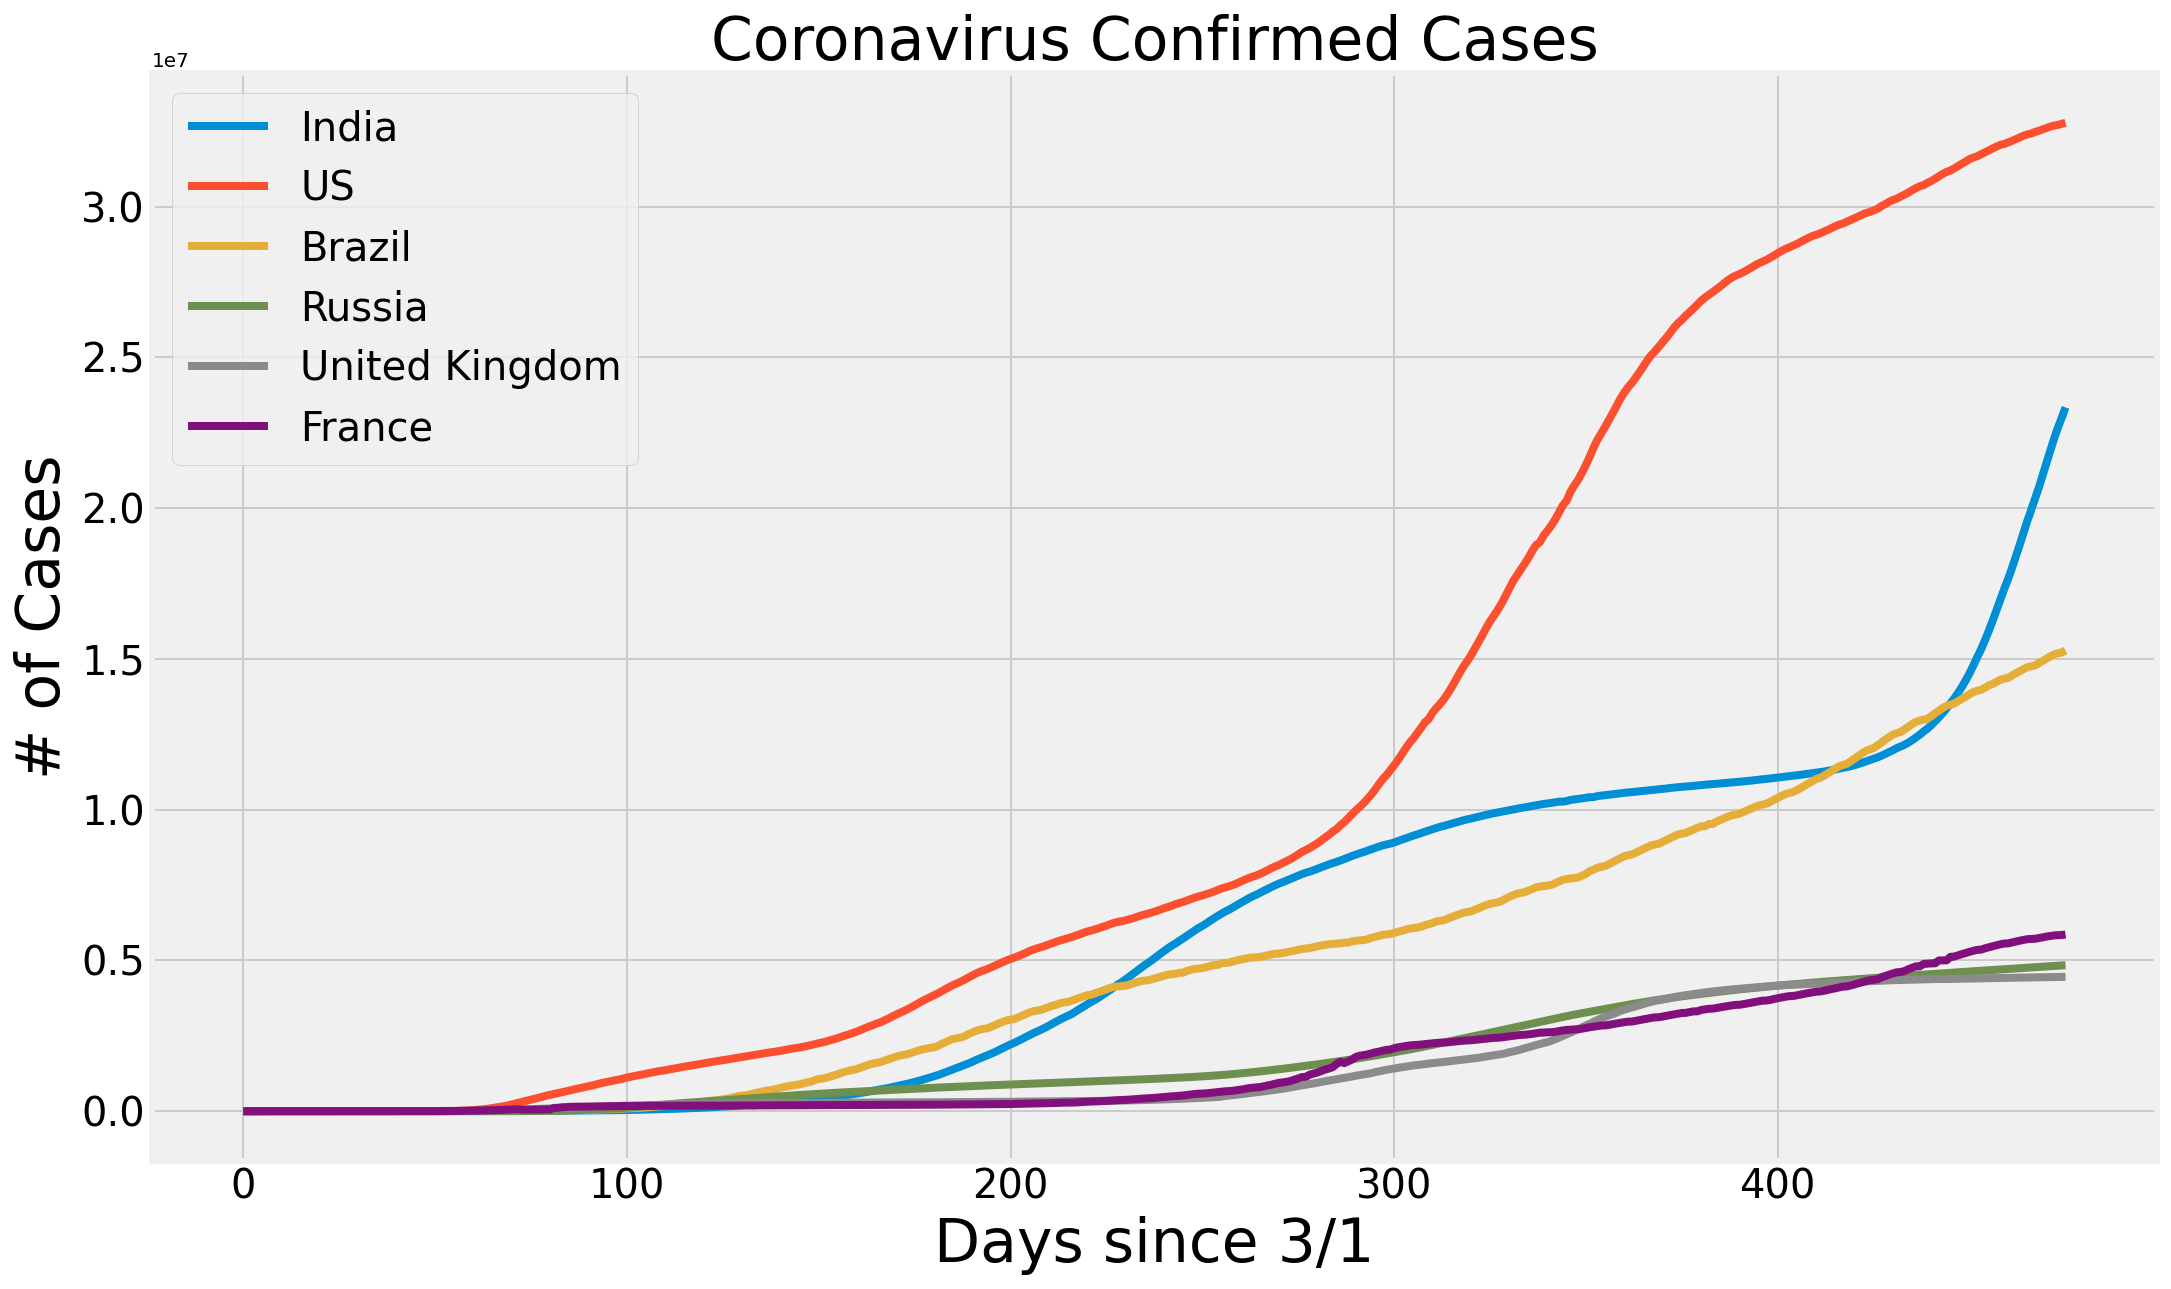

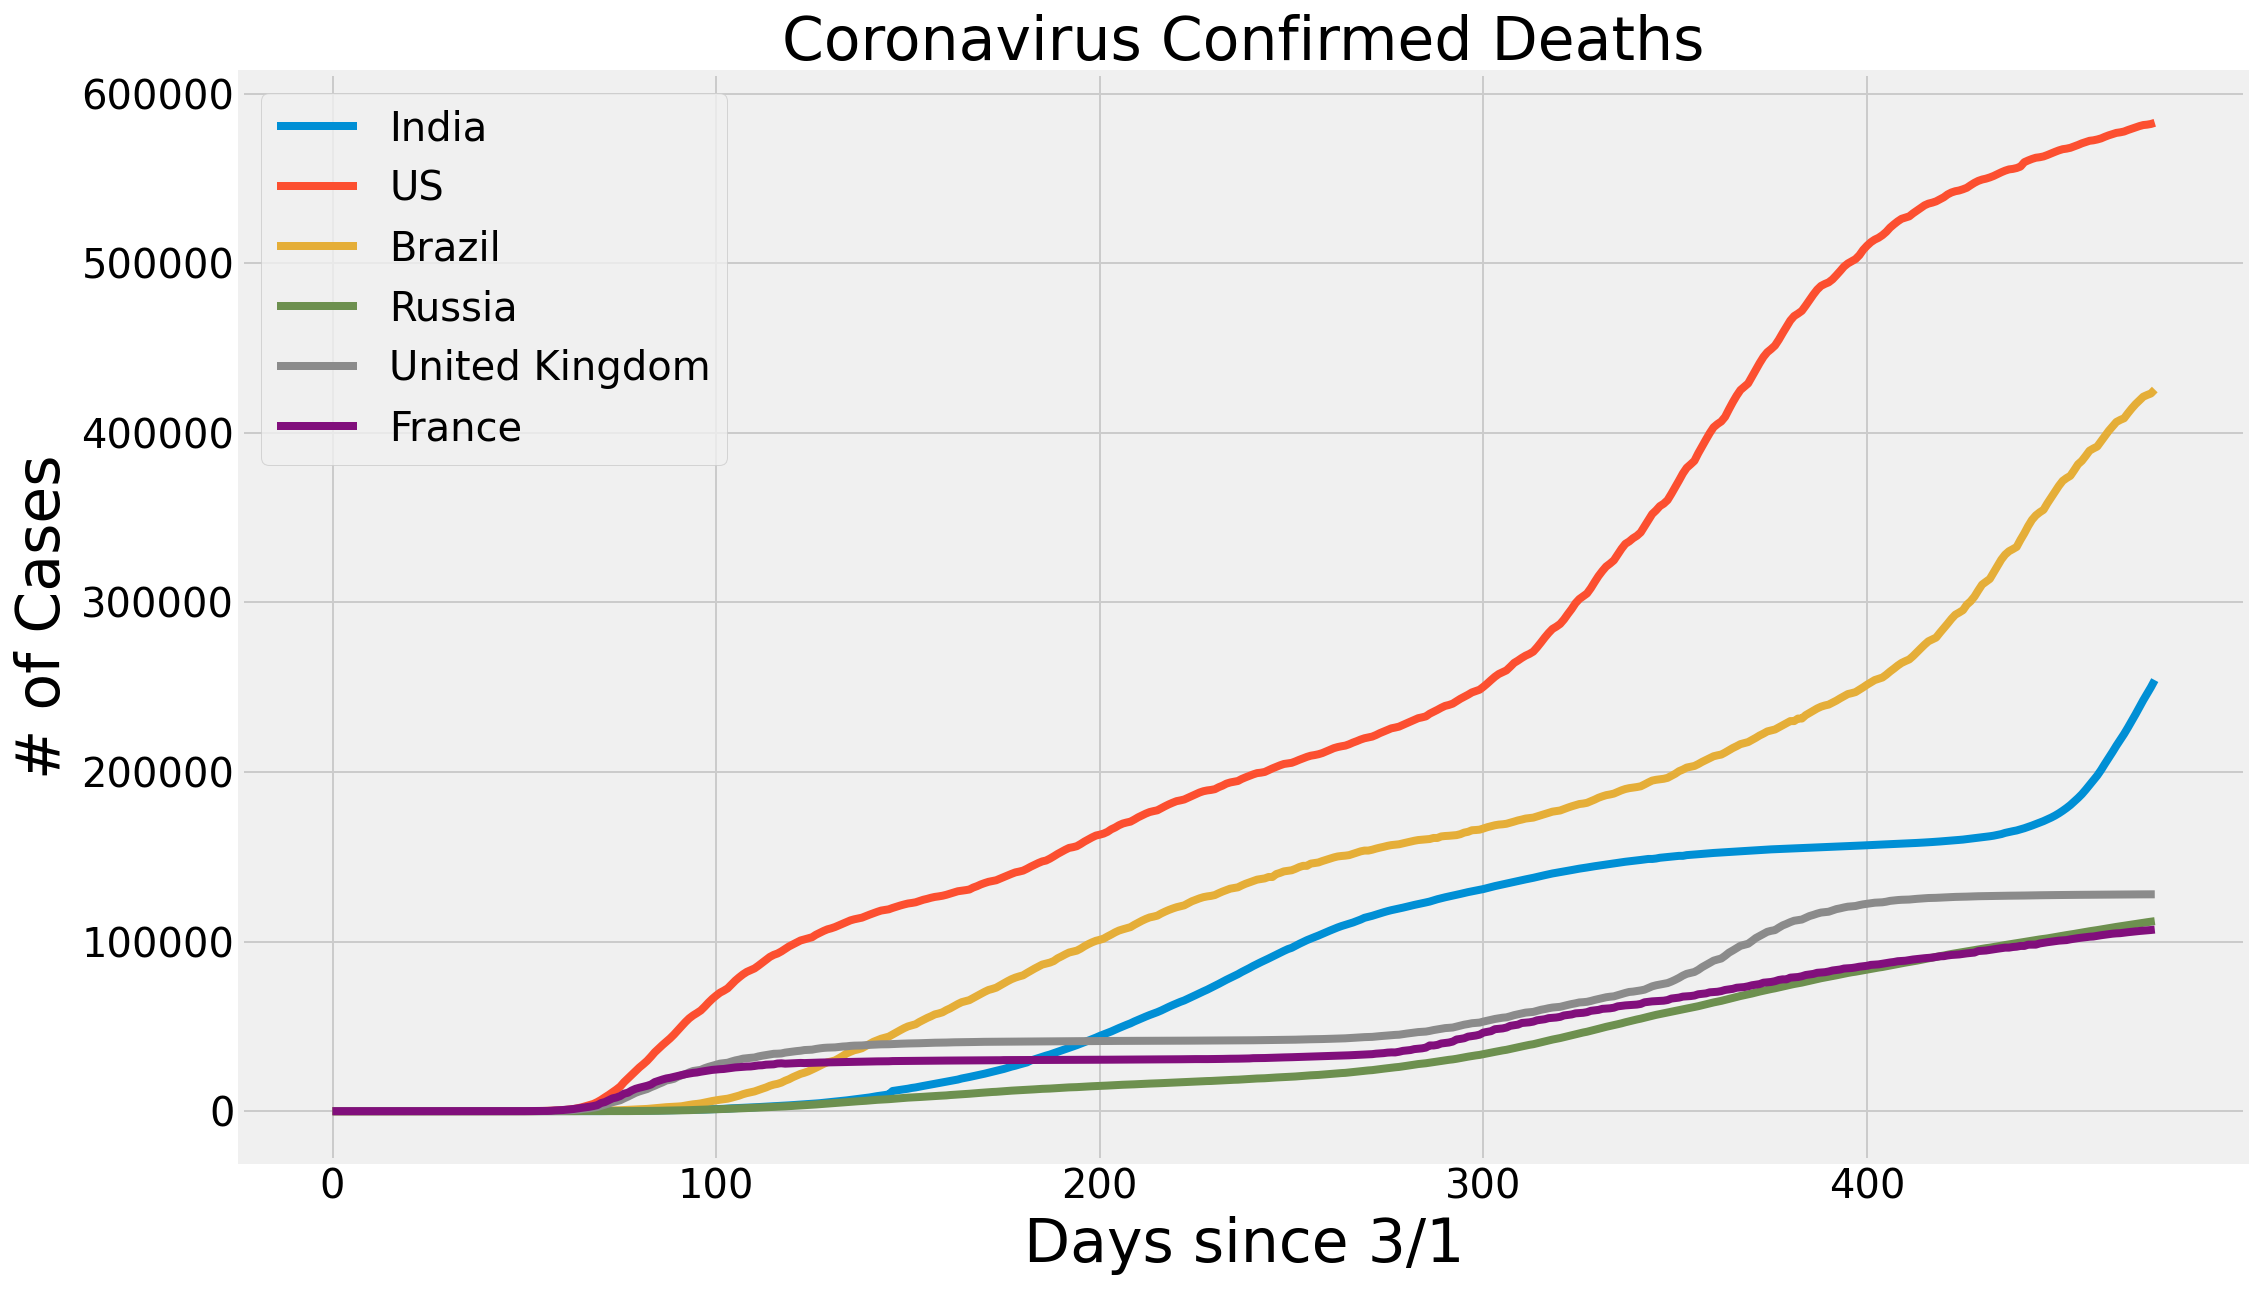

In [90]:
compare_countries = ['India', 'US', 'Brazil', 'Russia', 'United Kingdom', 'France'] 
graph_name = ['Coronavirus Confirmed Cases', 'Coronavirus Confirmed Deaths']

for num in range(2):
    plt.figure(figsize=(16, 10))
    for country in compare_countries:
        plt.plot(getCountryInfo(country)[num])
    plt.legend(compare_countries, prop={'size': 20})
    plt.xlabel('Days since 3/1', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.title(graph_name[num], size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

In [91]:
latestData

FIPS Admin2 Province_State      Country_Region          Last_Update  \
0      NaN    NaN            NaN         Afghanistan  2021-05-11 04:20:41   
1      NaN    NaN            NaN             Albania  2021-05-11 04:20:41   
2      NaN    NaN            NaN             Algeria  2021-05-11 04:20:41   
3      NaN    NaN            NaN             Andorra  2021-05-11 04:20:41   
4      NaN    NaN            NaN              Angola  2021-05-11 04:20:41   
...    ...    ...            ...                 ...                  ...   
3978   NaN    NaN            NaN             Vietnam  2021-05-11 04:20:41   
3979   NaN    NaN            NaN  West Bank and Gaza  2021-05-11 04:20:41   
3980   NaN    NaN            NaN               Yemen  2021-05-11 04:20:41   
3981   NaN    NaN            NaN              Zambia  2021-05-11 04:20:41   
3982   NaN    NaN            NaN            Zimbabwe  2021-05-11 04:20:41   

            Lat       Long_  Confirmed  Deaths  Recovered   Active  \
0     33.939110   67.709953      62063    2698    54382.0   4983.0   
1     41.153300   20.168300     131753    2416   118041.0  11296.0   
2     28.033900    1.659600     124288    3335    86554.0  34399.0   
3     42.506300    1.521800      13429     127    13021.0    281.0   
4    -11.202700   17.873900      28875     636    24772.0   3467.0   
...         ...         ...        ...     ...        ...      ...   
3978  14.058324  108.277199       3489      35     2618.0    836.0   
3979  31.952200   35.233200     302249    3378   287206.0  11665.0   
3980  15.552727   48.516388       6485    1275     3001.0   2209.0   
3981 -13.133897   27.849332      92112    1257    90501.0    354.0   
3982 -19.015438   29.154857      38433    1576    36208.0    649.0   

            Combined_Key  Incident_Rate  Case_Fatality_Ratio  
0            Afghanistan     159.428834             4.347196  
1                Albania    4578.254222             1.833734  
2                Algeria     283.432255             2.683284  
3                Andorra   17380.443927             0.945714  
4                 Angola      87.856035             2.202597  
...                  ...            ...                  ...  
3978             Vietnam       3.584396             1.003153  
3979  West Bank and Gaza    5924.805975             1.117622  
3980               Yemen      21.742798            19.660756  
3981              Zambia     501.045586             1.364643  
3982            Zimbabwe     258.582983             4.100643  

[3983 rows x 14 columns]

In [92]:
uniqueCountries =  list(latestData['Country_Region'].unique())

In [93]:
countryConfirmedCases = []
countryDeathCases = [] 
countryActiveCases = []
countryIncidenceRate = [] 
countryMortalRate = [] 

no_cases = []
for i in uniqueCountries:
    cases = latestData[latestData['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        countryConfirmedCases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    uniqueCountries.remove(i)
    
# sort countries by the number of confirmed cases
uniqueCountries = [k for k, v in sorted(zip(uniqueCountries, countryConfirmedCases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(uniqueCountries)):
    countryConfirmedCases[i] = latestData[latestData['Country_Region']==uniqueCountries[i]]['Confirmed'].sum()
    countryDeathCases.append(latestData[latestData['Country_Region']==uniqueCountries[i]]['Deaths'].sum())
#     country_recovery_cases.append(latestData[latestData['Country_Region']==uniqueCountries[i]]['Recovered'].sum())
    countryActiveCases.append(latestData[latestData['Country_Region']==uniqueCountries[i]]['Active'].sum())
    countryIncidenceRate.append(latestData[latestData['Country_Region']==uniqueCountries[i]]['Incident_Rate'].sum())
    countryMortalRate.append(countryDeathCases[i]/countryConfirmedCases[i])

In [94]:
countryDF = pd.DataFrame({'Country Name': uniqueCountries, 'Number of Confirmed Cases': [format(int(i), ',d') for i in countryConfirmedCases],
                          'Number of Deaths': [format(int(i), ',d') for i in countryDeathCases], 
                          'Number of Active Cases' : [format(int(i), ',d') for i in countryActiveCases], 'Incidence Rate' : countryIncidenceRate,
                          'Mortality Rate': countryMortalRate})
# number of cases per country/region

countryDF.style.background_gradient(cmap='Oranges')

In [95]:
# return the data table with province/state info for a given country
def country_table(country_name):
    states = list(latestData[latestData['Country_Region']==country_name]['Province_State'].unique())
    stateConfirmedCases = []
    stateDeathCases = [] 
    # state_recovery_cases = []
    stateActive = [] 
    stateIncidenceRate = [] 
    stateMortalRate = [] 

    no_cases = [] 
    for i in states:
        cases = latestData[latestData['Province_State']==i]['Confirmed'].sum()
        if cases > 0:
            stateConfirmedCases.append(cases)
        else:
            no_cases.append(i)

    # remove areas with no confirmed cases
    for i in no_cases:
        states.remove(i)

    states = [k for k, v in sorted(zip(states, stateConfirmedCases), key=operator.itemgetter(1), reverse=True)]
    for i in range(len(states)):
        stateConfirmedCases[i] = latestData[latestData['Province_State']==states[i]]['Confirmed'].sum()
        stateDeathCases.append(latestData[latestData['Province_State']==states[i]]['Deaths'].sum())
    #     state_recovery_cases.append(latestData[latestData['Province_State']==states[i]]['Recovered'].sum())
        stateActive.append(latestData[latestData['Province_State']==states[i]]['Active'].sum())
        stateIncidenceRate.append(latestData[latestData['Province_State']==states[i]]['Incident_Rate'].sum())
        stateMortalRate.append(stateDeathCases[i]/stateConfirmedCases[i])
        
      
    state_df = pd.DataFrame({'State Name': states, 'Number of Confirmed Cases': [format(int(i), ',d') for i in stateConfirmedCases],
                              'Number of Deaths': [format(int(i), ',d') for i in stateDeathCases], 'Number of Active Cases' : [format(int(i), ',d') for i in stateActive], 
                             'Incidence Rate' : stateIncidenceRate, 'Mortality Rate': stateMortalRate})
    # number of cases per country/region
    return state_df

In [96]:
indiaTable = country_table('India')
indiaTable.style.background_gradient(cmap='Oranges')

In [97]:
usTable = country_table('US')
usTable.style.background_gradient(cmap='Oranges')

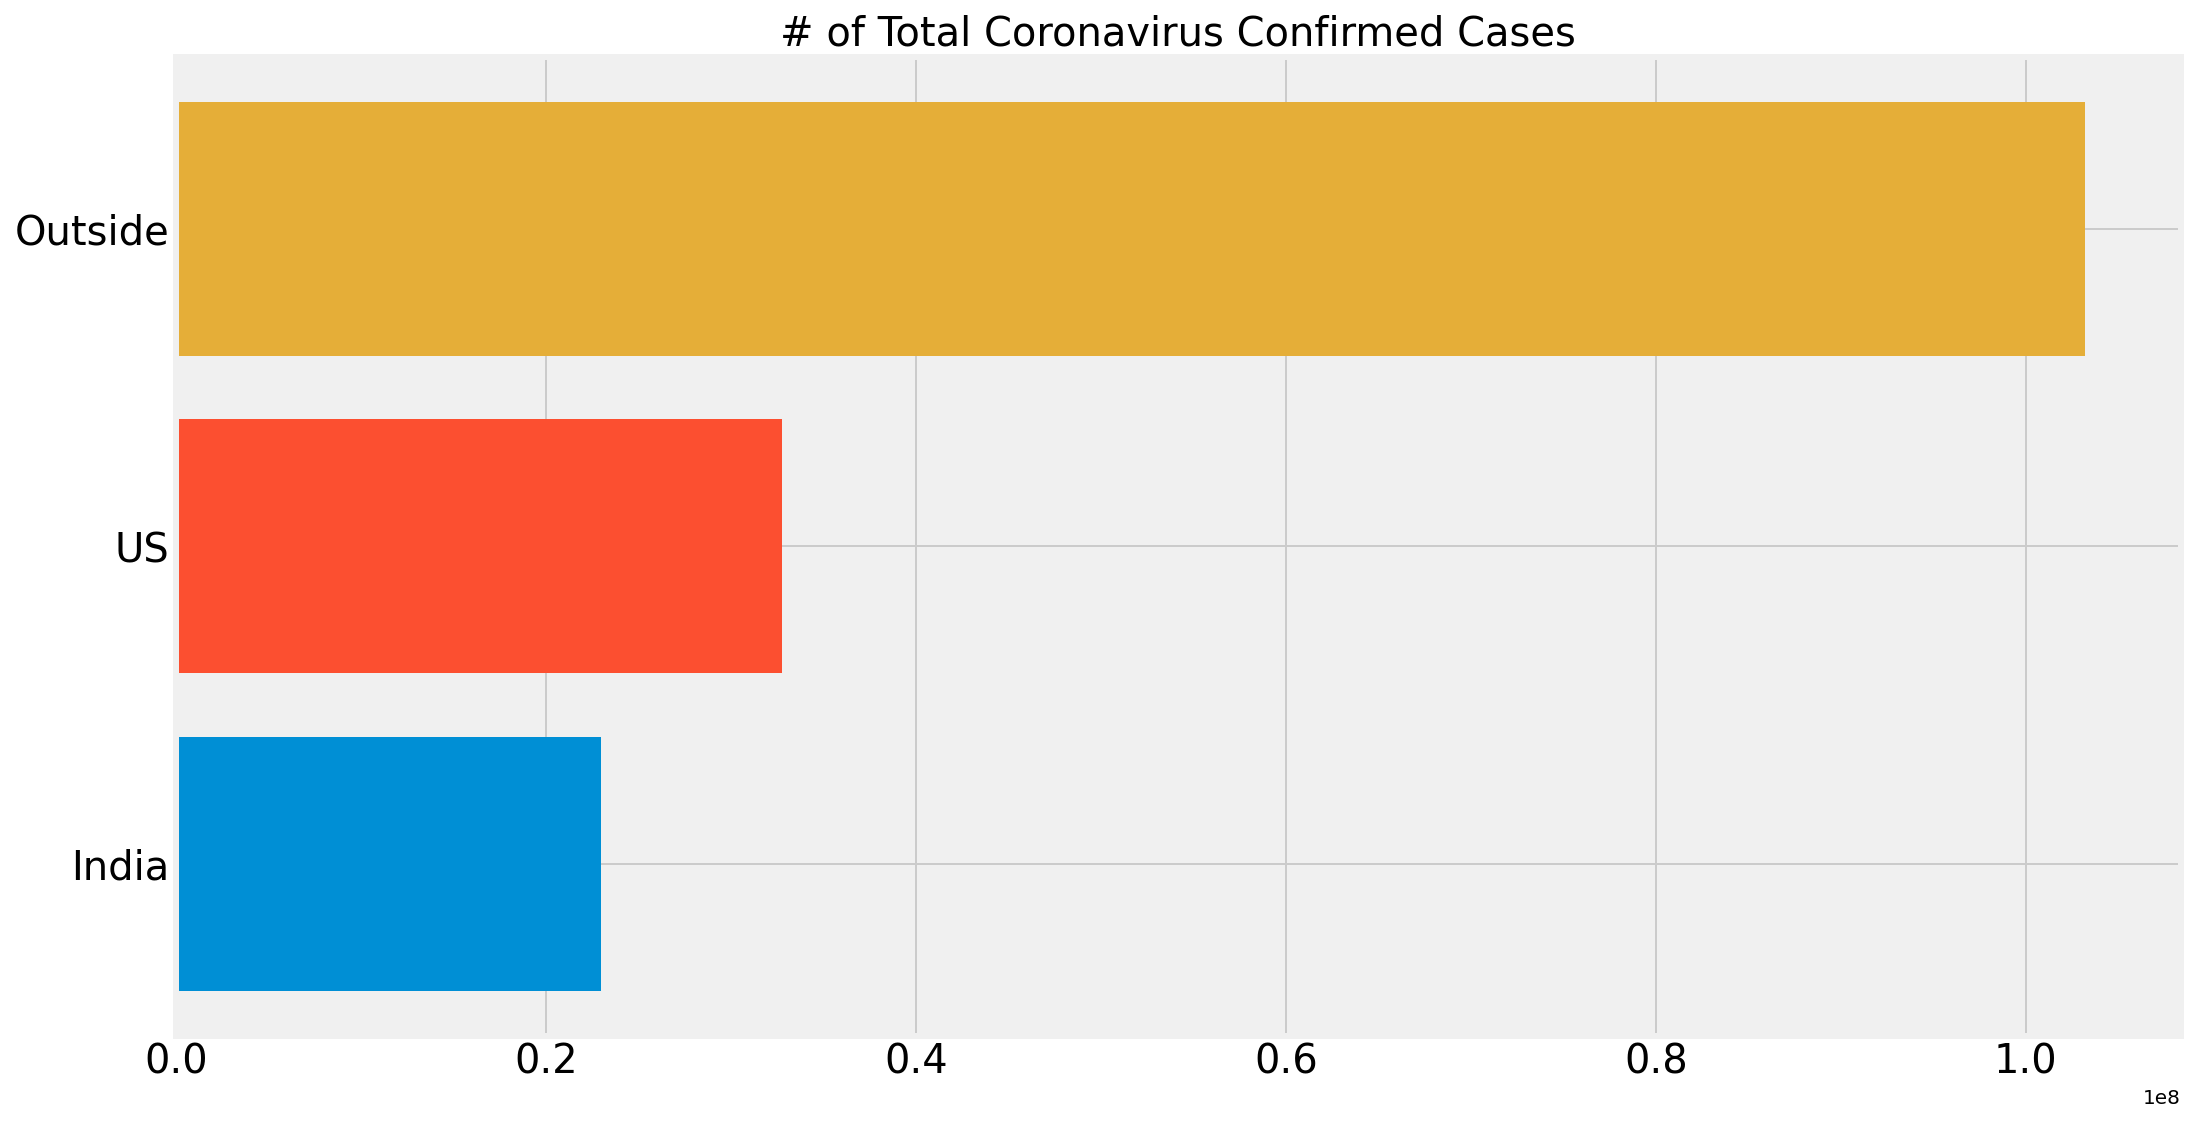

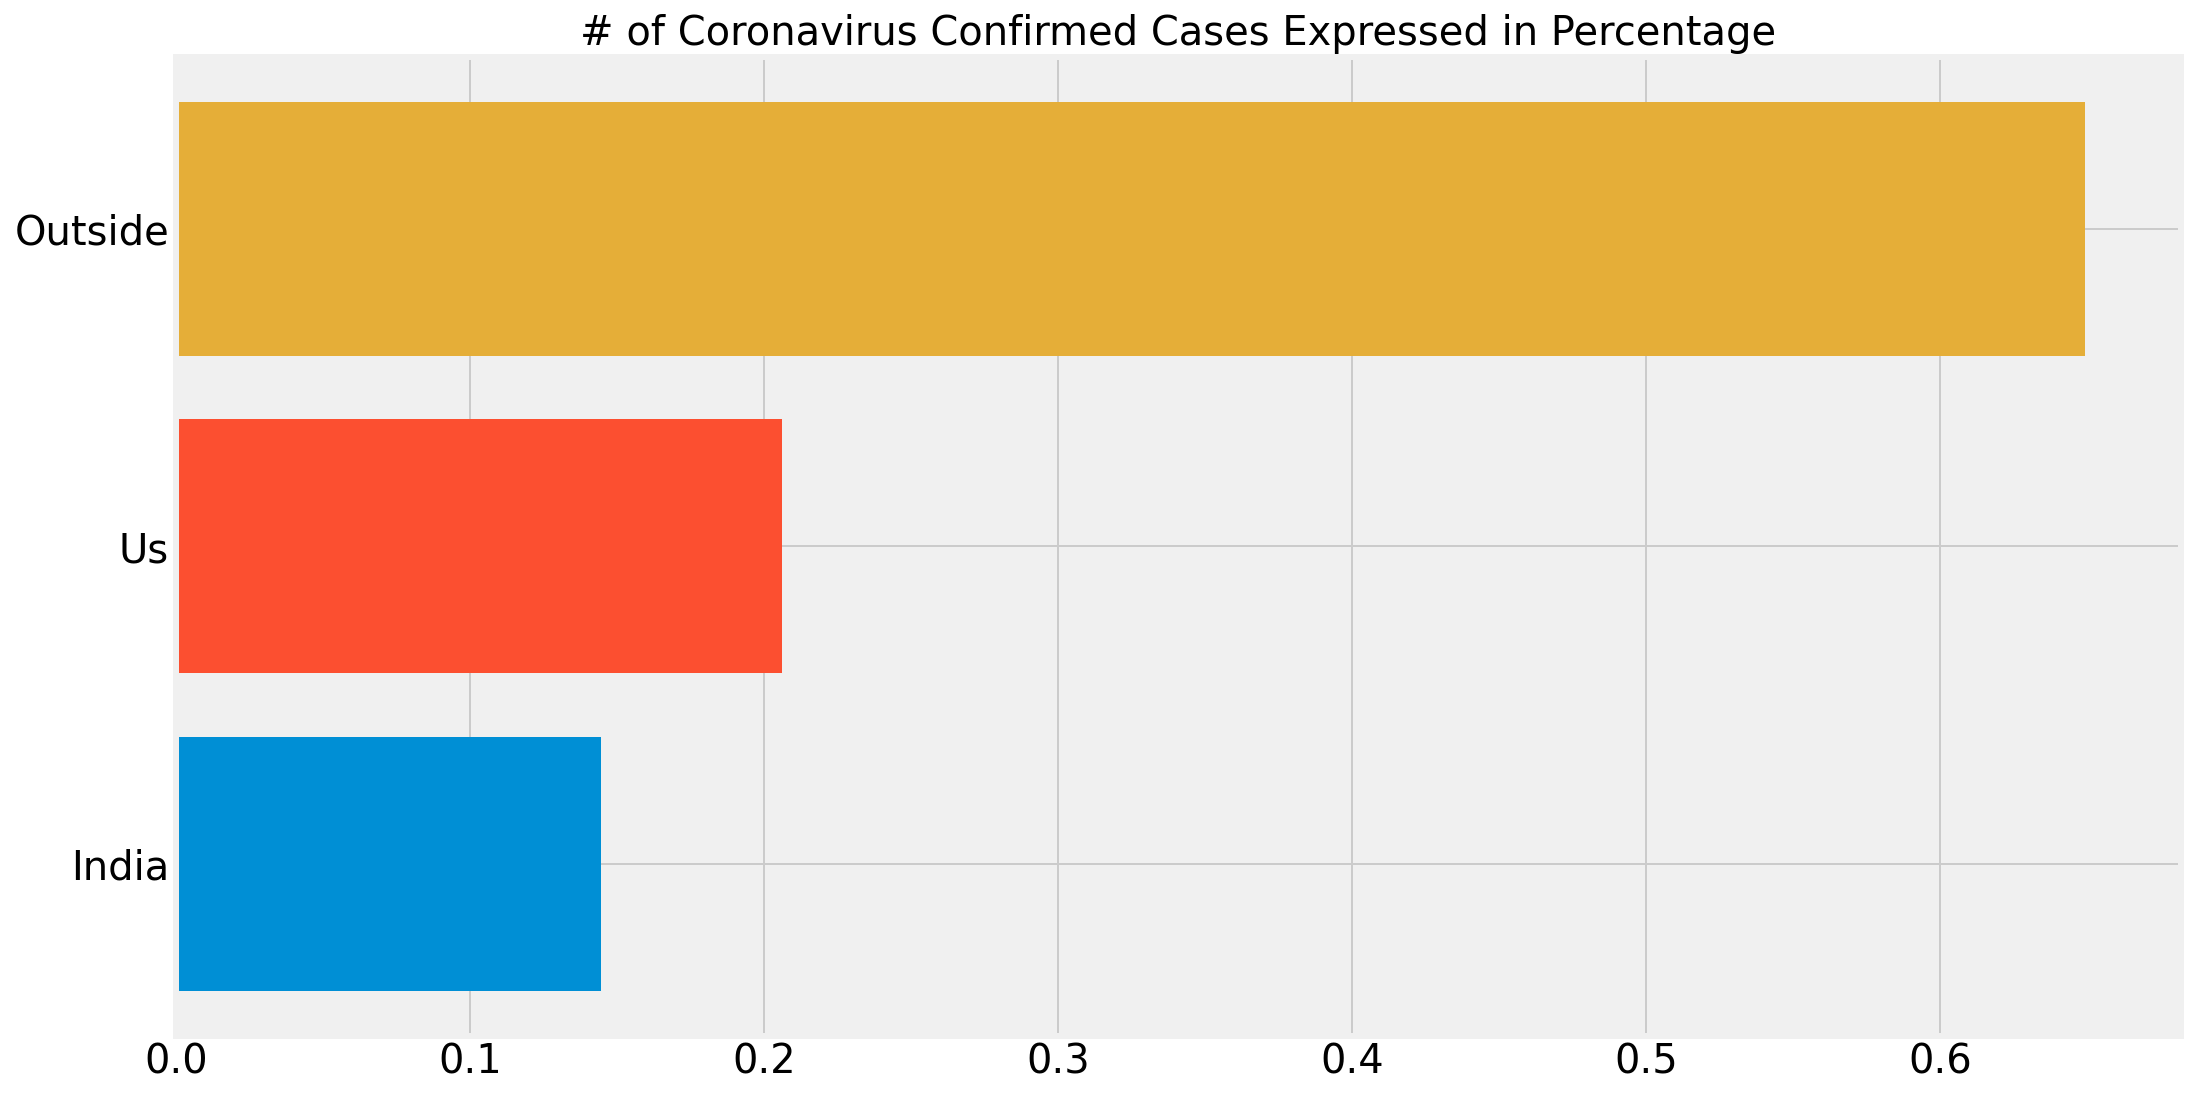

In [98]:
total_globalCases = np.sum(countryConfirmedCases)
india_confirmed = latestData[latestData['Country_Region']=='India']['Confirmed'].sum()
us_confirmed = latestData[latestData['Country_Region']=='US']['Confirmed'].sum()
outside_confirmed = total_globalCases - (india_confirmed + us_confirmed)

plt.figure(figsize=(16, 9))
plt.barh('India', india_confirmed)
plt.barh('US', us_confirmed)
plt.barh('Outside', outside_confirmed)
plt.title('# of Total Coronavirus Confirmed Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


plt.figure(figsize=(16, 9))
plt.barh('India', india_confirmed/total_globalCases)
plt.barh('Us', us_confirmed/total_globalCases)
plt.barh('Outside', outside_confirmed/total_globalCases)
plt.title('# of Coronavirus Confirmed Cases Expressed in Percentage', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [99]:
# Only show 10 countries with the most confirmed cases, the rest are grouped into the other category
visualUniqueCountries = [] 
visualConfirmedCases = []
others = np.sum(countryConfirmedCases[10:])

for i in range(len(countryConfirmedCases[:10])):
    visualUniqueCountries.append(uniqueCountries[i])
    visualConfirmedCases.append(countryConfirmedCases[i])
    
visualUniqueCountries.append('Others')
visualConfirmedCases.append(others)

In [100]:
def plotBarGraphs(x, y, title):
    plt.figure(figsize=(16, 12))
    plt.barh(x, y)
    plt.title(title, size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()
    
# good for a lot x values 
def plotBarGraphs_tall(x, y, title):
    plt.figure(figsize=(19, 18))
    plt.barh(x, y)
    plt.title(title, size=25)
    plt.xticks(size=25)
    plt.yticks(size=25)
    plt.show()

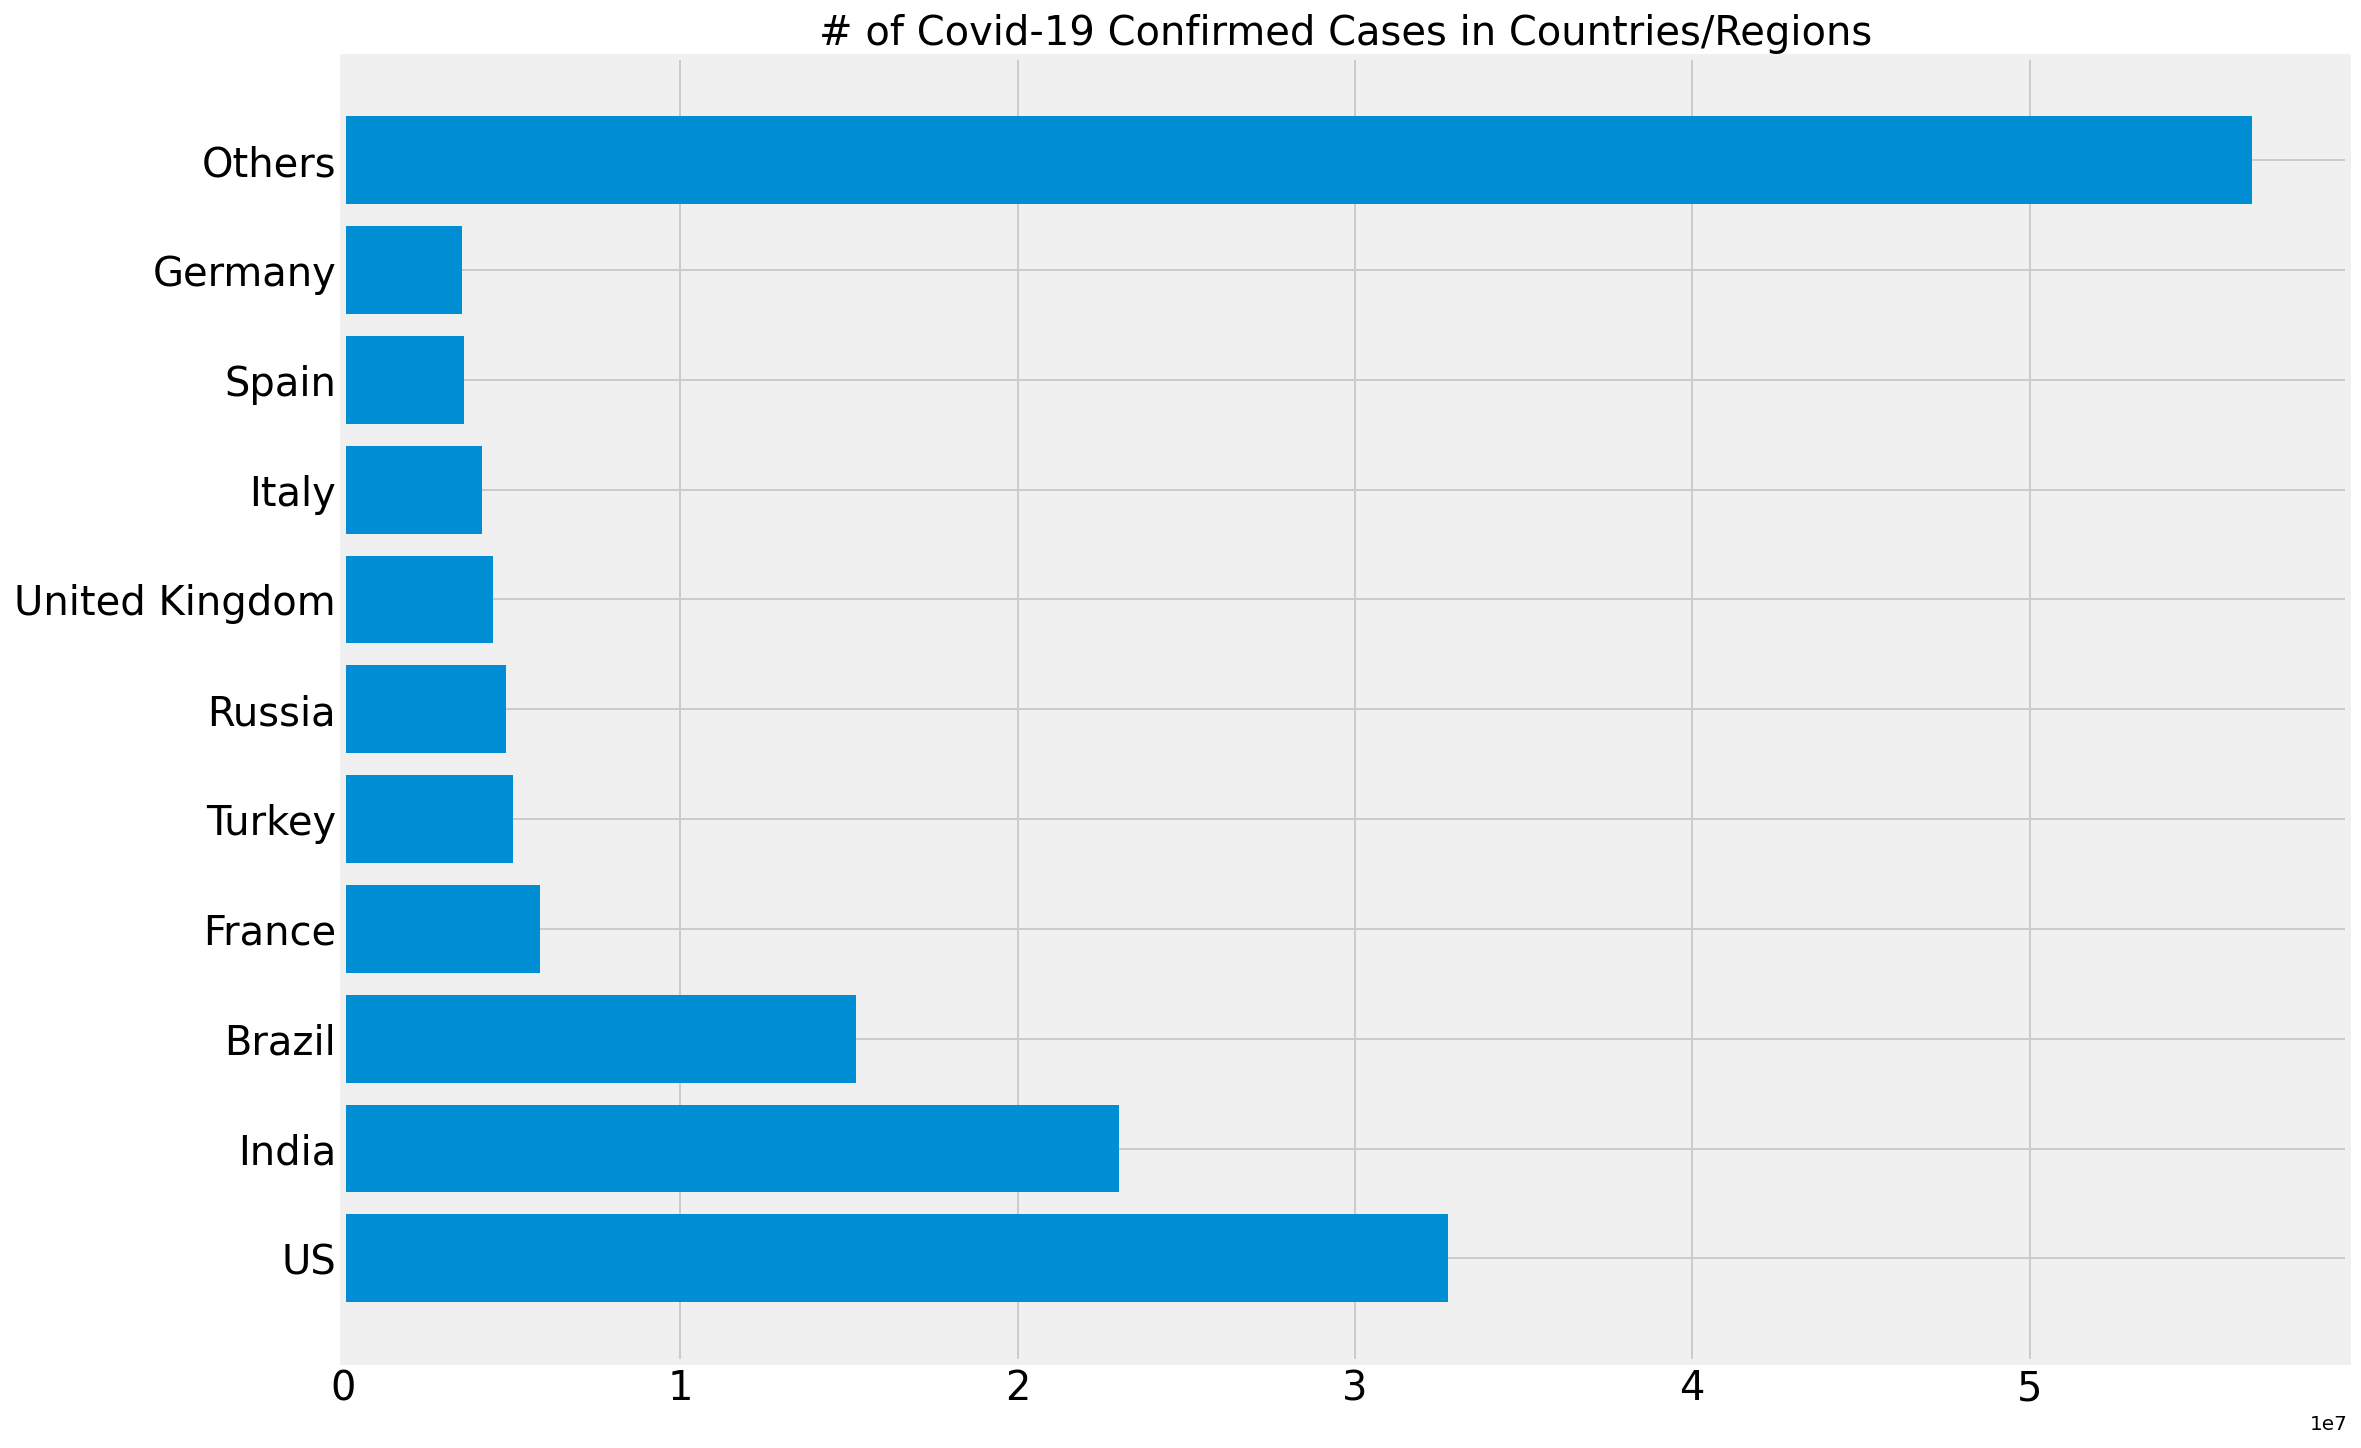

In [101]:
plotBarGraphs(visualUniqueCountries, visualConfirmedCases, '# of Covid-19 Confirmed Cases in Countries/Regions')

In [102]:
def plot_pie_charts(x, y, title):
    # more muted color 
    c = ['lightcoral', 'rosybrown', 'sandybrown', 'navajowhite', 'gold',
        'khaki', 'lightskyblue', 'turquoise', 'lightslategrey', 'thistle', 'pink']
    plt.figure(figsize=(20,15))
    plt.title(title, size=20)
    plt.pie(y, colors=c,shadow=True, labels=y)
    plt.legend(x, loc='best', fontsize=12)
    plt.show()

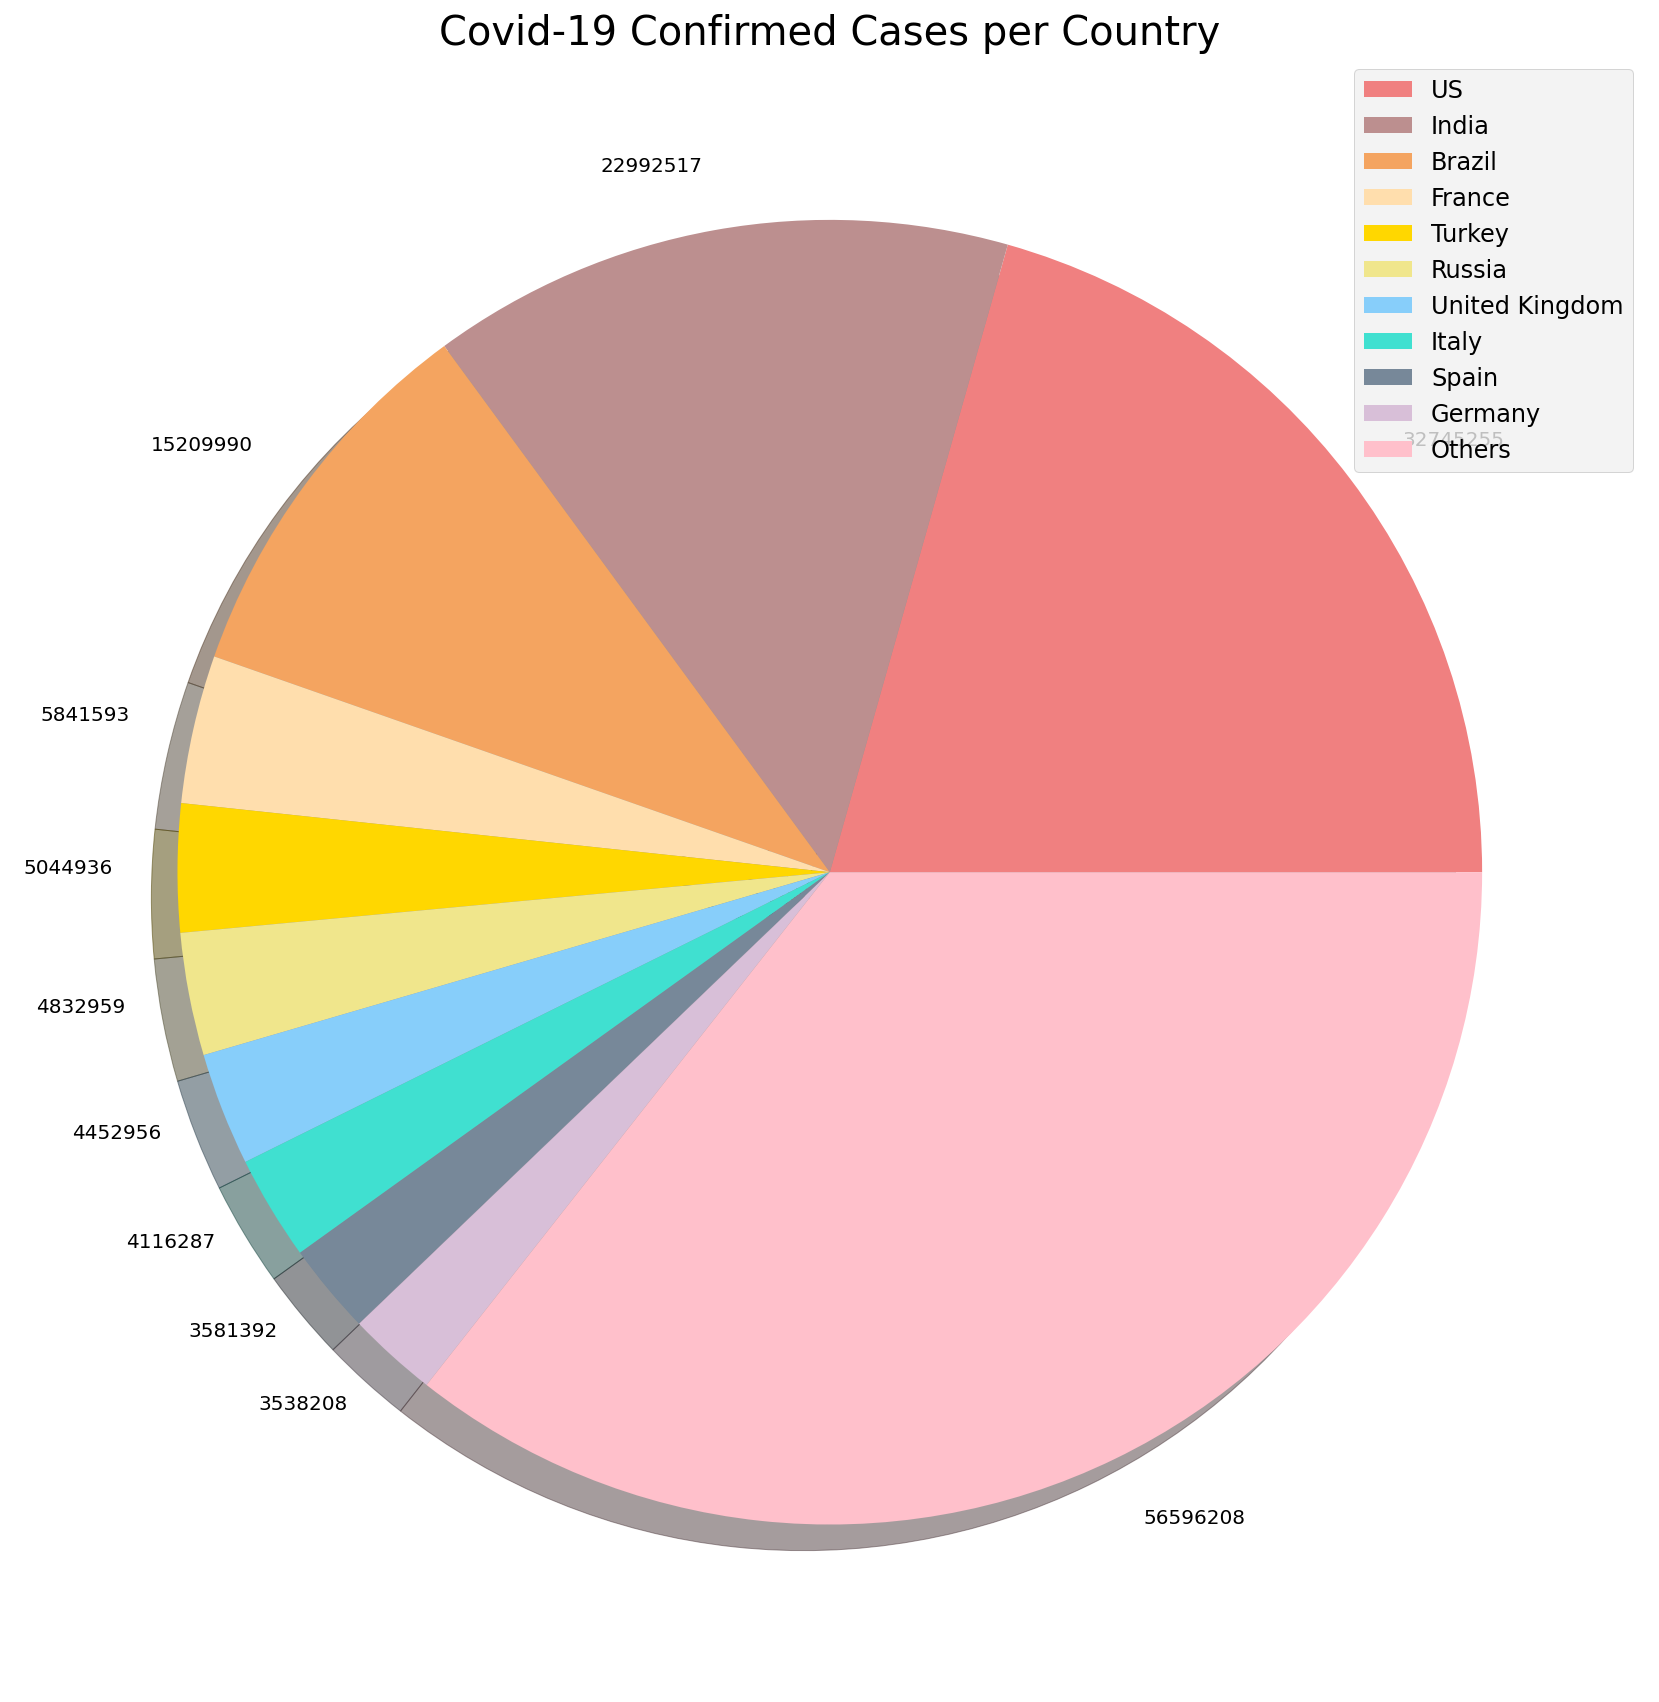

In [103]:
plot_pie_charts(visualUniqueCountries, visualConfirmedCases, 'Covid-19 Confirmed Cases per Country')

In [105]:
# plot_pie_charts(visual_unique_provinces, visual_confirmed_cases2, 'Covid-19 Confirmed Cases per State/Province/Region')

In [106]:
def plotPredictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 10))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('Worldwide Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

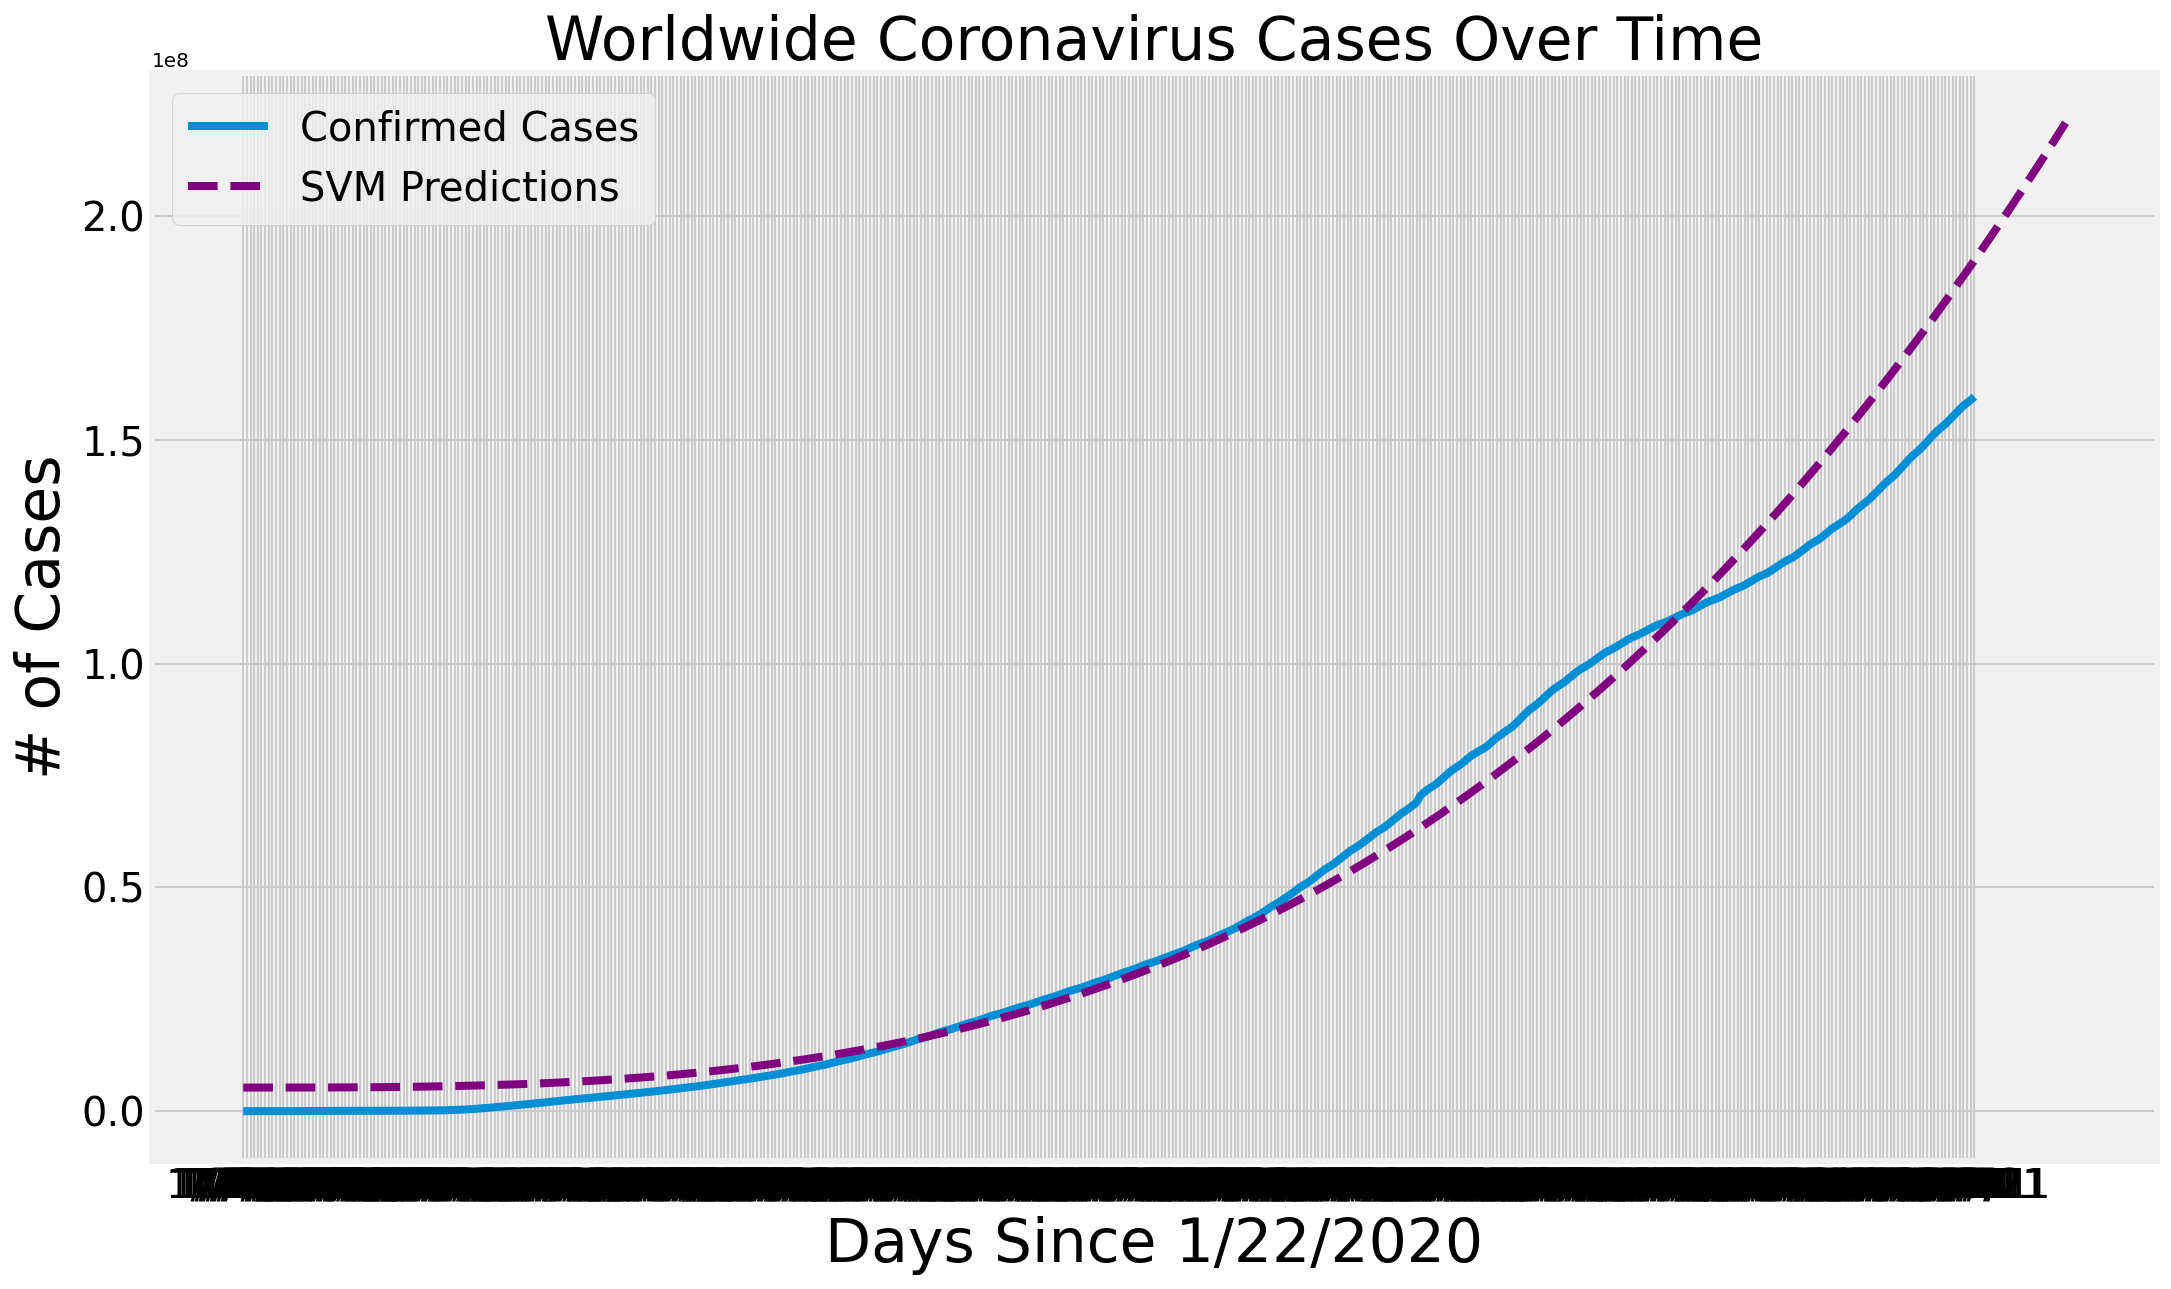

In [107]:
plotPredictions(dates, globalCases, svmPred, 'SVM Predictions', 'purple')

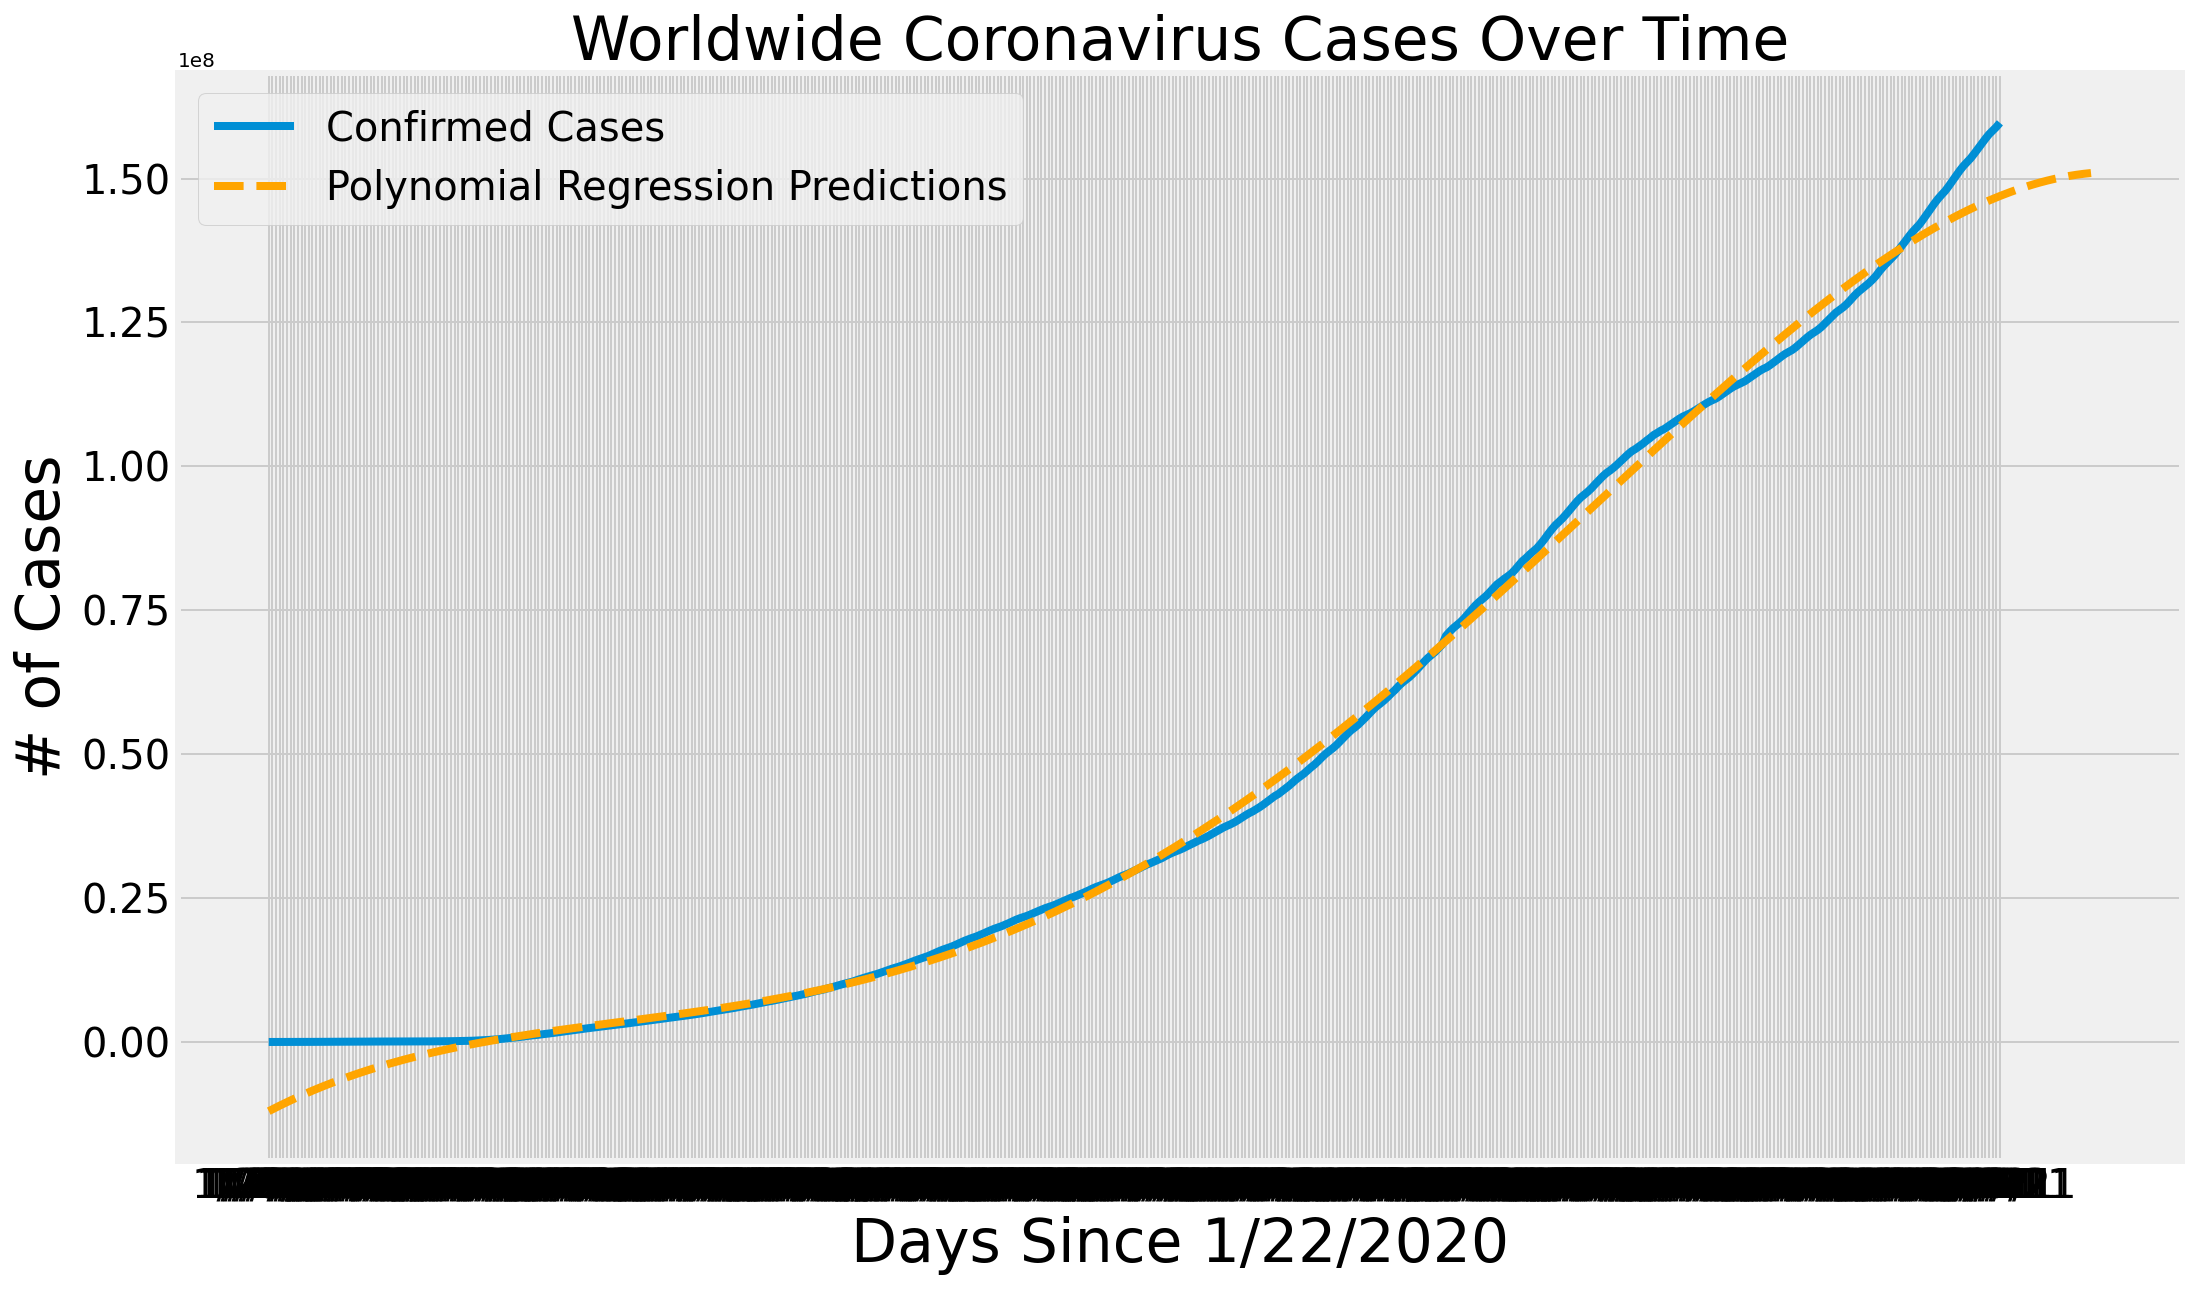

In [108]:
plotPredictions(dates, globalCases, linearPred, 'Polynomial Regression Predictions', 'orange')

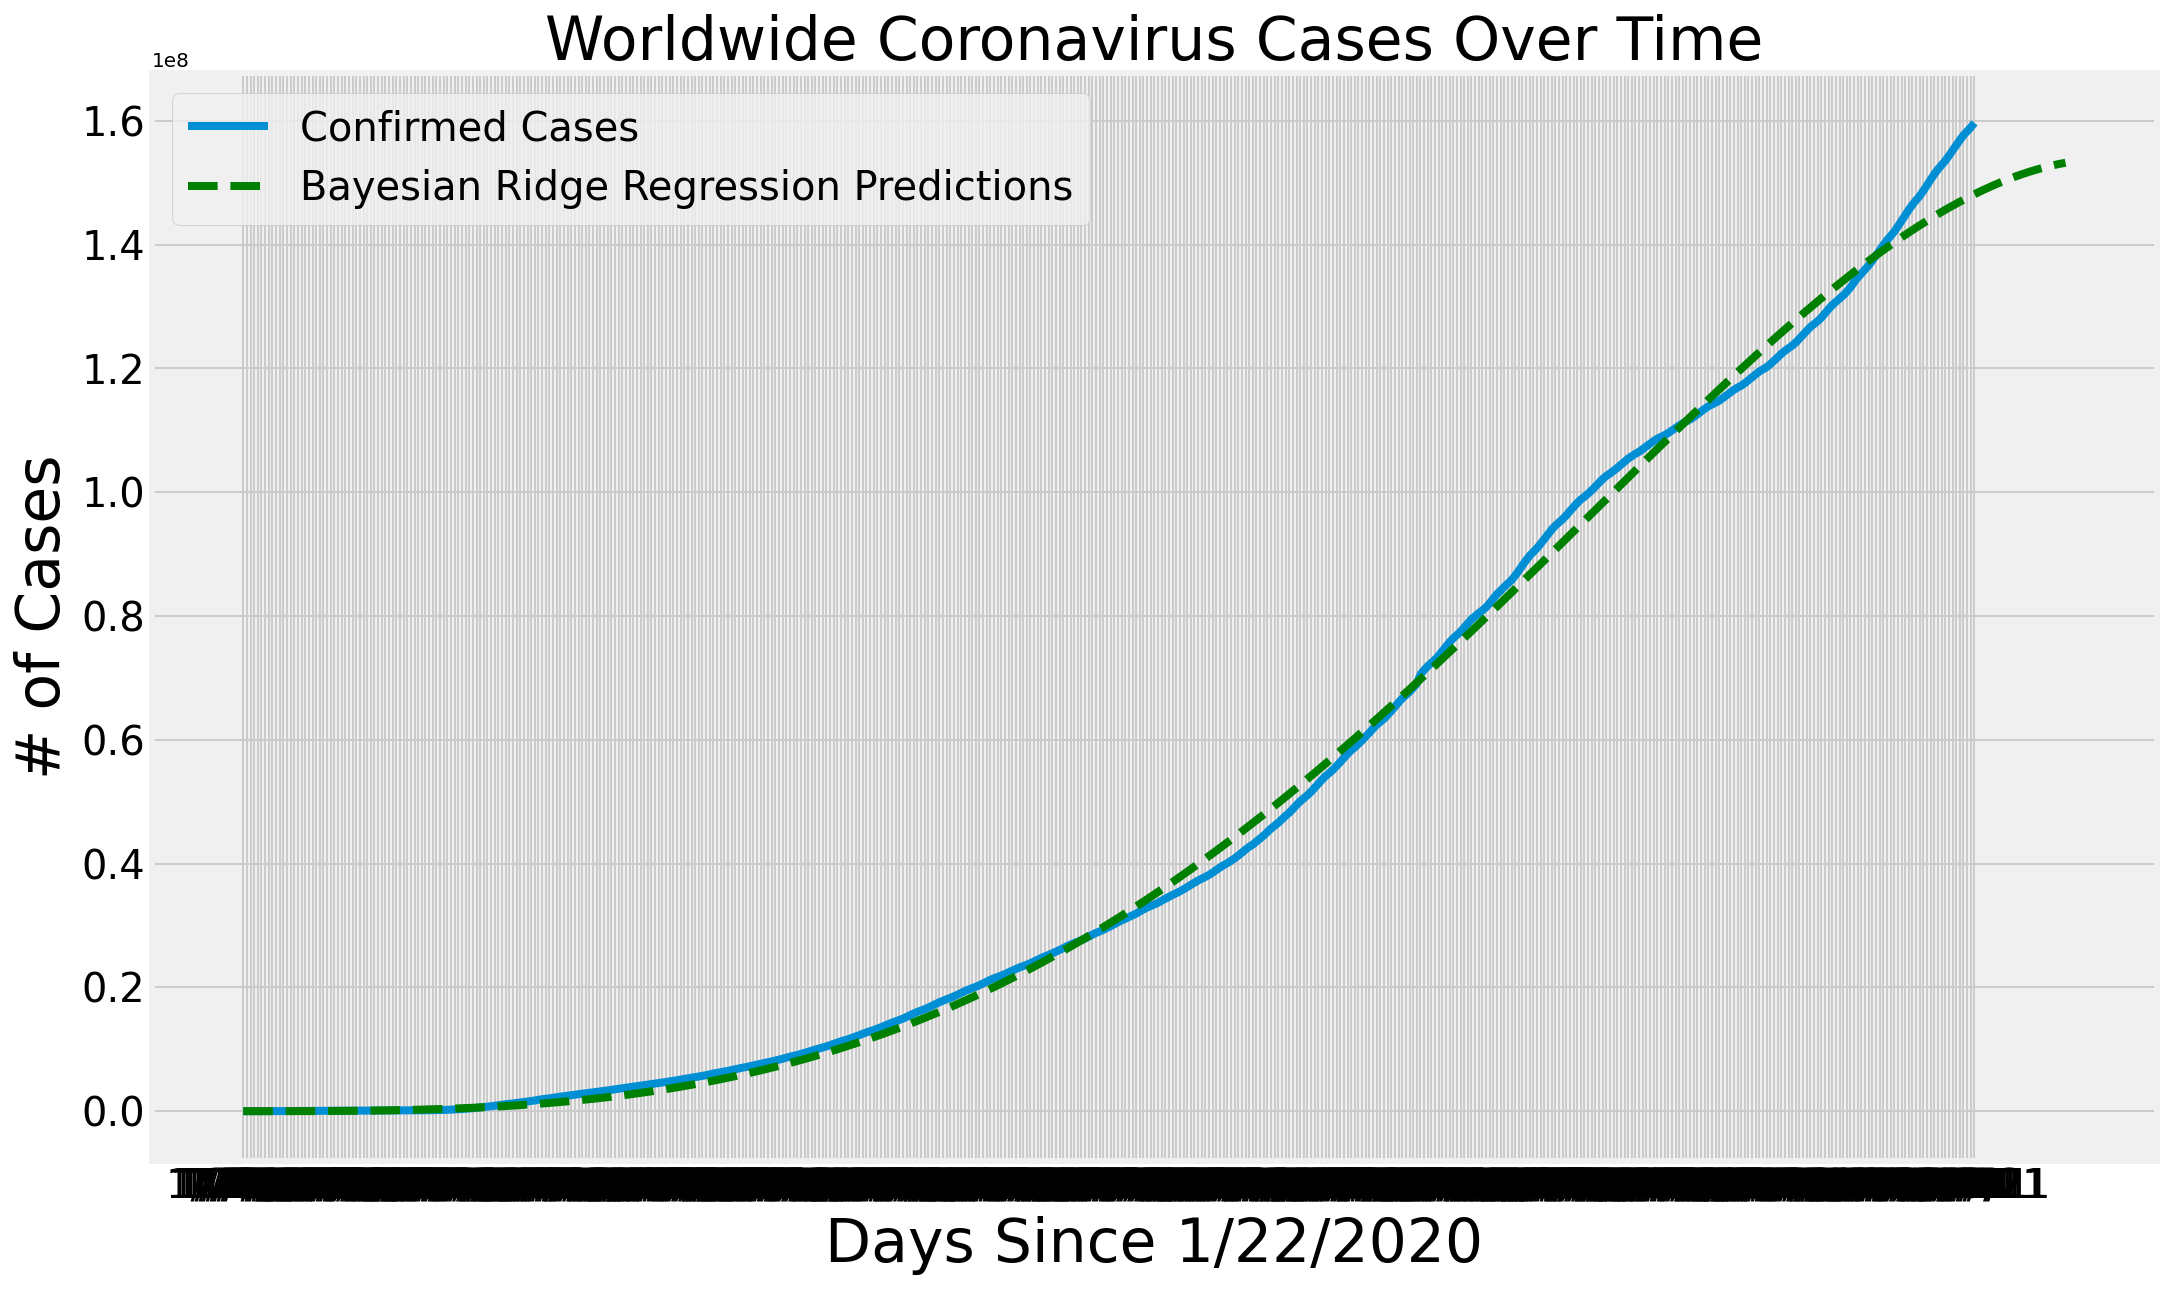

In [109]:
plotPredictions(dates, globalCases, bayesianPred, 'Bayesian Ridge Regression Predictions', 'green')